In [1]:
#Colab
#!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 6.8 MB/s eta 0:00:00


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import math
import pandas as pd
import xgboost
import lightgbm
import catboost

from matplotlib.colors import ListedColormap
from scipy.stats import pearsonr
from itertools import combinations
from sklearn.base import BaseEstimator
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (RandomForestClassifier,
                              ExtraTreesClassifier,
                              VotingClassifier)
from sklearn.tree import (DecisionTreeRegressor,
                          DecisionTreeClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import (r2_score, roc_auc_score, roc_curve, accuracy_score, f1_score, matthews_corrcoef,
                             mean_squared_error, confusion_matrix, ConfusionMatrixDisplay)

In [3]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Bias-variance trade-off

**2 балла**

Продемонстрируйте bias-variance trade-off для `DecisionTreeRegressor` при изменении глубины дерева. Постройте регрессионную модель функции от одной независимой переменной, представленной в ячейке ниже, используя функцию `plot_regression_predictions` (можете ее как-то поменять, если захочется). Попробуйте разные значения глубины деревьев, при каком значении, на ваш взгляд, модель оптимальна, при каком variance становится слишком большим?

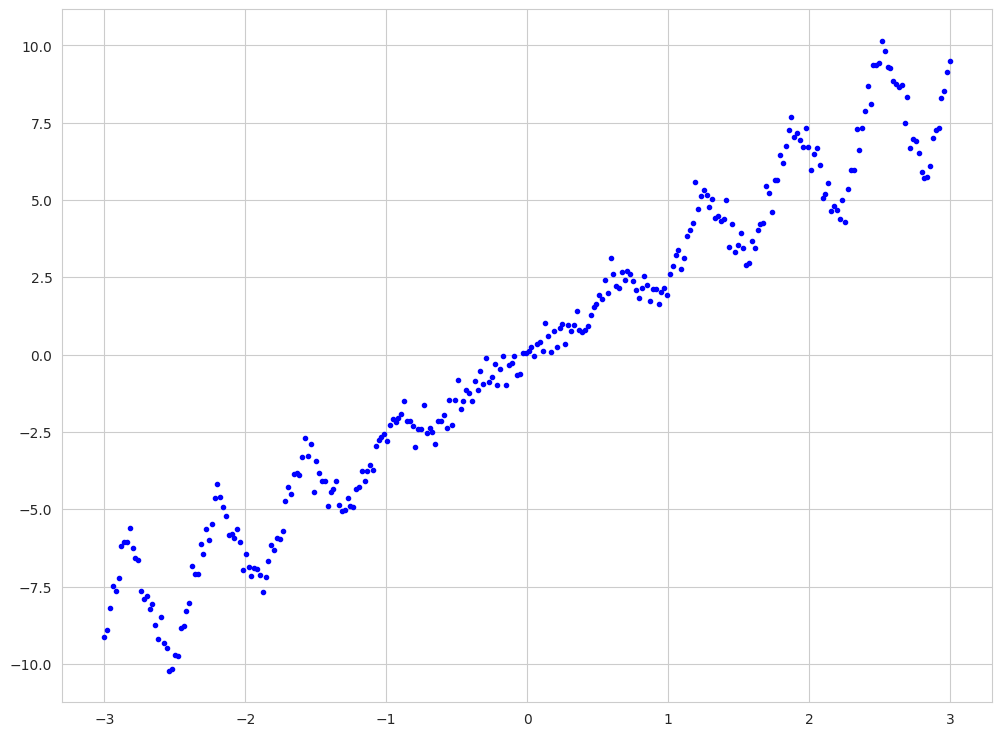

In [ ]:
# Сгенерируем какую-нибудь необычную зависимость и научимся ее предсказывать
np.random.seed(42)
m = 300
X = np.linspace(-3, 3, m).reshape(-1, 1)
y = (3 + 2/np.pi * np.arcsin(np.cos(10 * X))) * X
y = y + np.random.randn(m, 1) / 3
plt.plot(X.reshape(-1), y.reshape(-1), "b.");

In [ ]:
# Функция для отрисовки предсказаний деревьев решений в случае регрессии
def plot_regression_predictions(tree_reg, X, y, axes=[-3, 3, -10, 10], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)

    plt.plot(x1, y_pred, linewidth=2, label=r"$\hat{y}$")

Изобразите, как меняются предсказания дерева при увеличении максимальной глубины (можно взять что-то в диапазоне от 1 до 15):

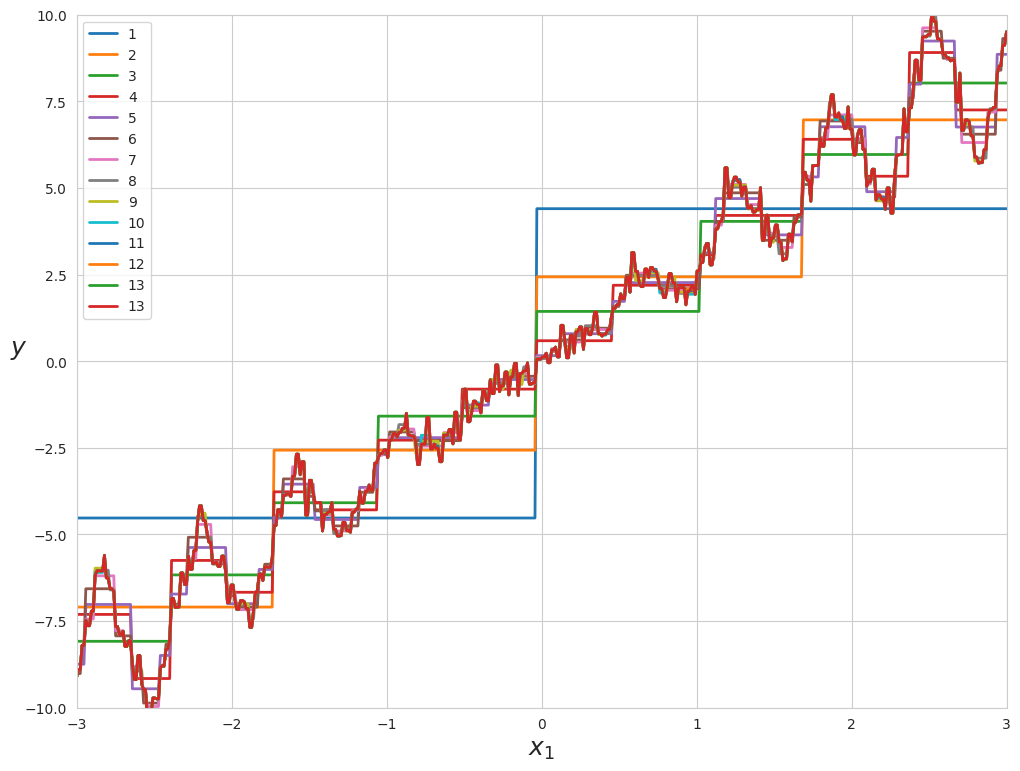

In [ ]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

depths = []
for depth in range(1, 15):
    regressor = DecisionTreeRegressor(max_depth=depth, random_state=SEED)
    regressor.fit(X, y)
    depths.append(regressor.get_depth())
    plot_regression_predictions(regressor, X, y)
plt.legend(depths);

> Получается, что для меньших значений глубины (синий) деление грубее <=> большой bias, для больших значений глубины (красный) деление детальнее <=> большой variance.

### Задание 2. Random forest

Теперь давайте немного подготовимся к тому, чтобы реализовать свой собственный случайный лес, а потом реализуем его.

#### Задание 2. 1. Простое ансамблирование

**1 балла**

Представим, что у нас есть 101 классификатор. Каждый может с вероятностью `p` (равной для всех моделей) правильно предсказать класс объекта. Будем делать предсказания по большинству голосов (majority vote). Постройте зависимость вероятности правильно классифицировать объект от значения `p`. Вам может быть полезная следующая формула:

$$ \large \mu = \sum_ {i = 51} ^ {101} C_{101} ^ ip ^ i (1-p) ^ {101-i} $$

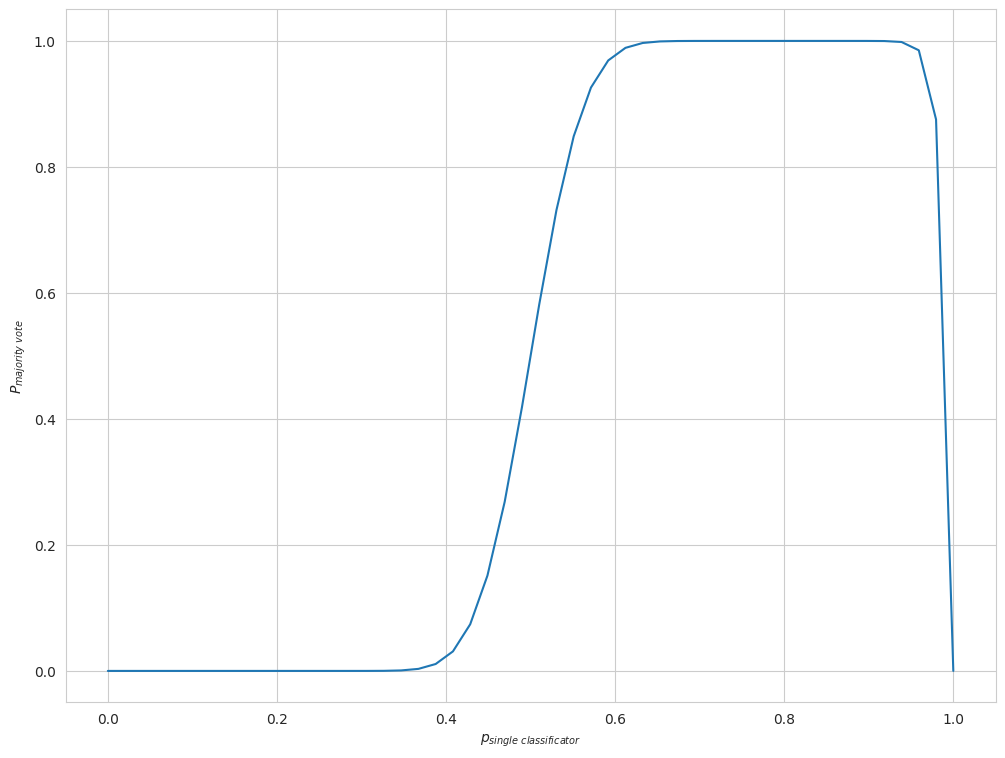

In [ ]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
p_s = np.linspace(0, 1)
x = []
y = []

for p in p_s:
    p_total = 0
    for i in range(51, 101):
        p_total += (math.factorial(101)/(math.factorial(i)*math.factorial(101-i))) * p**i * (1-p)**(101-i)
    y.append(p_total)
    x.append(p)

plt.xlabel('$p_{single\ classificator}$')
plt.ylabel('$P_{majority\ vote}$')
plt.plot(x,y);

>После вероятности правильной классификации ~0.4 для отдельных классификаторов начинает расти вероятность итогового предсказания (по majority vote). А при ~0.7 уже 1 предсказать верно для ансамбля.

А теперь давайте посмотрим на другую ситуацию. У нас есть фиксированная вероятность того, что модель правильно классифицирует объект `p = 0.65`. Постройте зависимость вероятности правильно классифицировать объект от числа моделей в ансамбле.

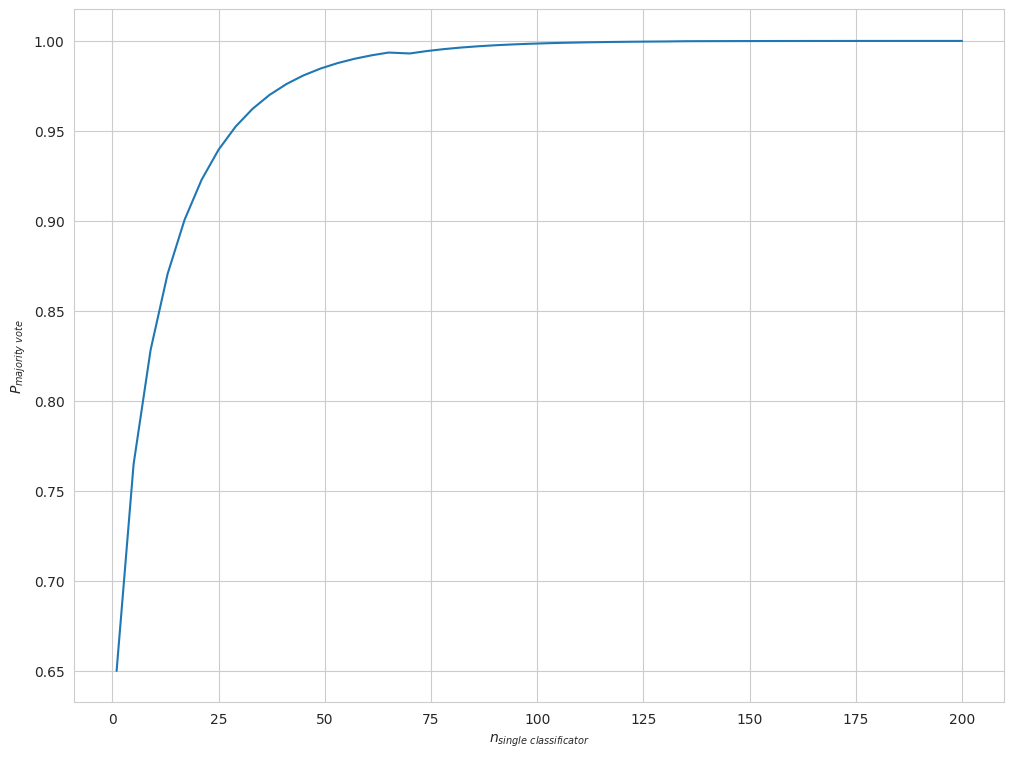

In [ ]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
n_s = list(map(int, np.linspace(1, 200)))
p = 0.65
x = []
y = []

for n in n_s:
    p_total = 0
    for i in range(n//2+1, n+1):
        p_total += (math.factorial(n)/(math.factorial(i)*math.factorial(n-i))) * p**i * (1-p)**(n-i)
    y.append(p_total)
    x.append(n)

plt.xlabel('$n_{single\ classificator}$')
plt.ylabel('$P_{majority\ vote}$')
plt.plot(x,y);

> В целом после 100 классификаторов кривая выходит на насыщение (к 1), т.е. с определённого момента качество предсказание не меняется, с увеличением количества отдельных классификаторов.

Опишите ваши наблюдения:

* если делать предсказания по большинству голосов (majority vote), то при вероятности отдельного классификатора > 0.6 вероятность предсказать класс объекта правильно ~1.
* если есть фиксированная вероятность (0,65) того, что модель правильно классифицирует объект, то при >100 таких классификаторов предсказать класс объекта правильно ~1.

#### Задание 2. 2. Реализация простого RF

**4 балла**

Реализуйте свой собственный класс `RandomForestClassifierCustom`, используя в качестве базовой модели `DecisionTreeClassifier` из `sklearn`.

Небольшое описание:
- Используйте приведенный ниже код
- В методе `fit` в цикле (`i` от 0 до `n_estimators-1`):
    * Зафиксируйте генератор случайных чисел следующим образом np.random.seed(`random_state + i`). Идея в том, что на каждой итерации у нас будет новое значение для генератора случайных чисел, что добавит побольше "случайности", но в то же время мы сможем иметь воспроизводимые результаты
    * После чего выберите `max_features` признаков **без возвращения/without replacement**, сохраните список выбранных признаков (их индексов) в `self.feat_ids_by_tree`
    * Также создайте псевдовыборку при помощи бутстрэпа (выбор **с возвращением/with replacement**) из тренировочных данных. Может помочь функция `np.random.choice` и ее аргумент `replace`
    * Обучите дерево решений с параметрами, заданными в конструкторе класса `max_depth`, `max_features` и `random_state` на полученной псевдовыборке.
- Метод `fit` должен возвращать текущий экземпляр класса `RandomForestClassifierCustom`, то есть `self` (все по-взрослому, как в `sklearn`)
- В методе `predict_proba` мы должны пройти циклом по всем деревьям. Для каждого предсказания, нам нужно будет брать только те признаки, на которых училось изначальное дерево, поэтому мы и сохраняли эту информацию в артрибуте `self.feat_ids_by_tree`. Этот метод должен возвращать предсказанные вероятности (можно делать двумя способами: для каждого дерева предсказывать значение при помощи метода `predict_proba` и потом усреднять эти вероятности, или к примеру пользоваться методом `predict` и также считать среднее.

In [ ]:
class RandomForestClassifierCustom(BaseEstimator):
    def __init__(
        self, n_estimators=10, max_depth=None, max_features=None, random_state=SEED
    ):
        self.n_estimators = n_estimators#сколько отдельных деревьев
        self.max_depth = max_depth
        self.max_features = max_features#сколько фичей берём
        self.random_state = random_state

        self.trees = []#для сохранения отдельных деревьев
        self.feat_ids_by_tree = []#сохраняем это для предикта

    def fit(self, X, y):
        self.classes_ = sorted(np.unique(y))

        ## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
        for i in range(self.n_estimators):
            np.random.seed(self.random_state + i)
            feat_ids_by_tree = np.random.choice(range(X.shape[1]), self.max_features, replace=False)#выбор признаков
            self.feat_ids_by_tree.append(feat_ids_by_tree)
            x_ids_bootstrap = np.random.choice(range(X.shape[0]), X.shape[0], replace=True)

            clf = DecisionTreeClassifier(max_depth=self.max_depth,
                                         max_features=self.max_features,
                                         random_state=self.random_state)
            clf.fit(X[x_ids_bootstrap, :][:, feat_ids_by_tree], y[x_ids_bootstrap])

            self.trees.append(clf)
        return self

    def predict_proba(self, X):
        ## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
        y_pred_s = []
        for i in range(self.n_estimators):
            clf = self.trees[i]
            feat_ids_by_tree = self.feat_ids_by_tree[i]
            y_pred_s.append(clf.predict_proba(X[:, feat_ids_by_tree]))
        return np.mean(y_pred_s, axis=0)

    def predict(self, X):
        probas = self.predict_proba(X)
        predictions = np.argmax(probas, axis=1)

        return predictions

Протестируем нашу реализацию на искусственных данных. Визуализируйте разделяющую границу, которую рисует ваша модель при помощи функции `plot_decision_boundary` (см. примеры в лекции).

In [ ]:
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(["#ffdab9","#9898ff", "#4B0082"])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(["#ffdab9", "#4c4c7f", "#4B0082"])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

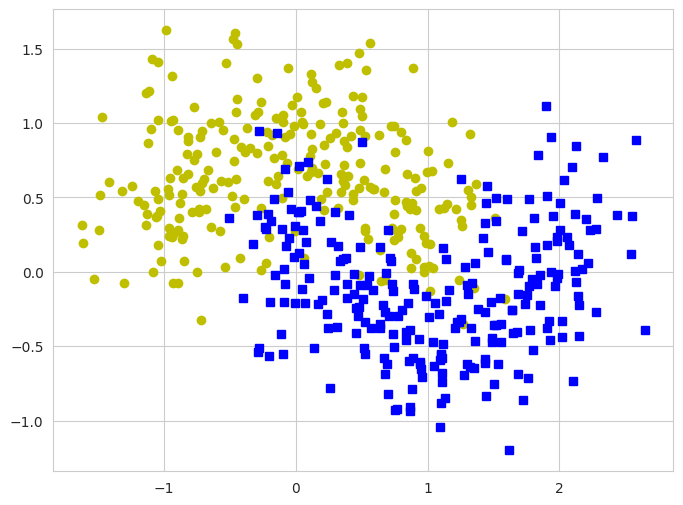

In [ ]:
X, y = datasets.make_moons(n_samples=500, noise=0.30, random_state=SEED)

plt.figure(figsize=(8, 6))
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.show()

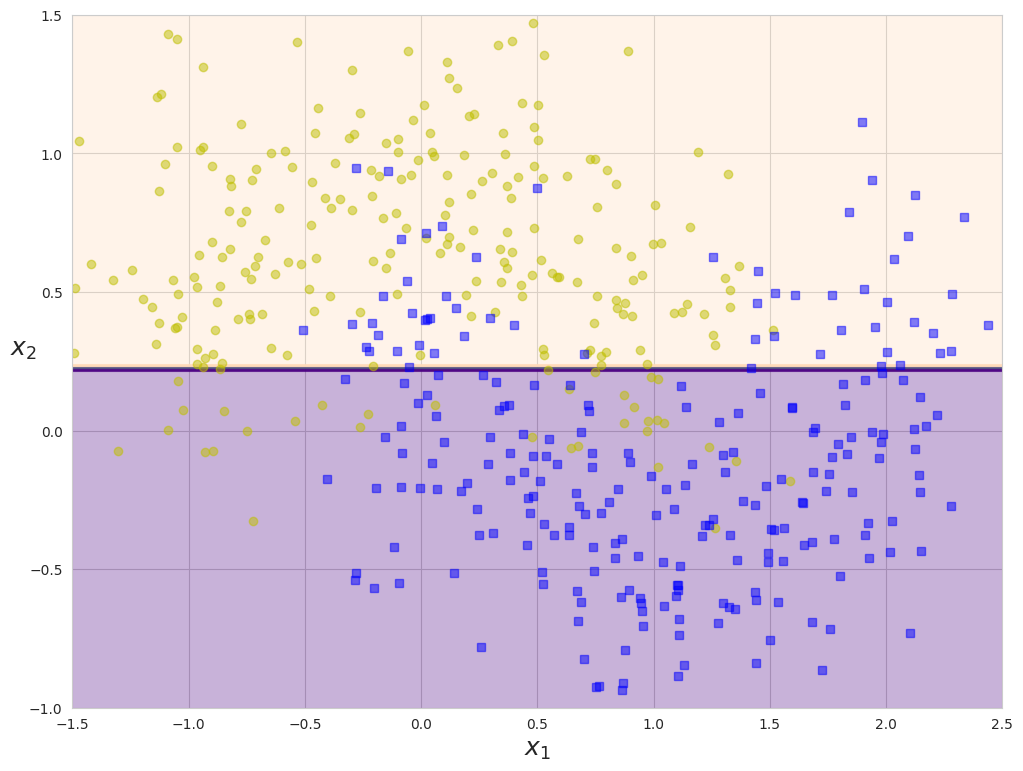

In [ ]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
my_clf = RandomForestClassifierCustom(max_depth=1, n_estimators=50, max_features=2)
my_clf.fit(X, y)
plot_decision_boundary(my_clf, X, y)

Подберите наилучшие гиперпараметры, при которых разделяющая граница будет, на ваш взгляд, оптимальной с точки зрения bias-variance. Можно также подключить какие-то метрики для выбора лучшей модели.

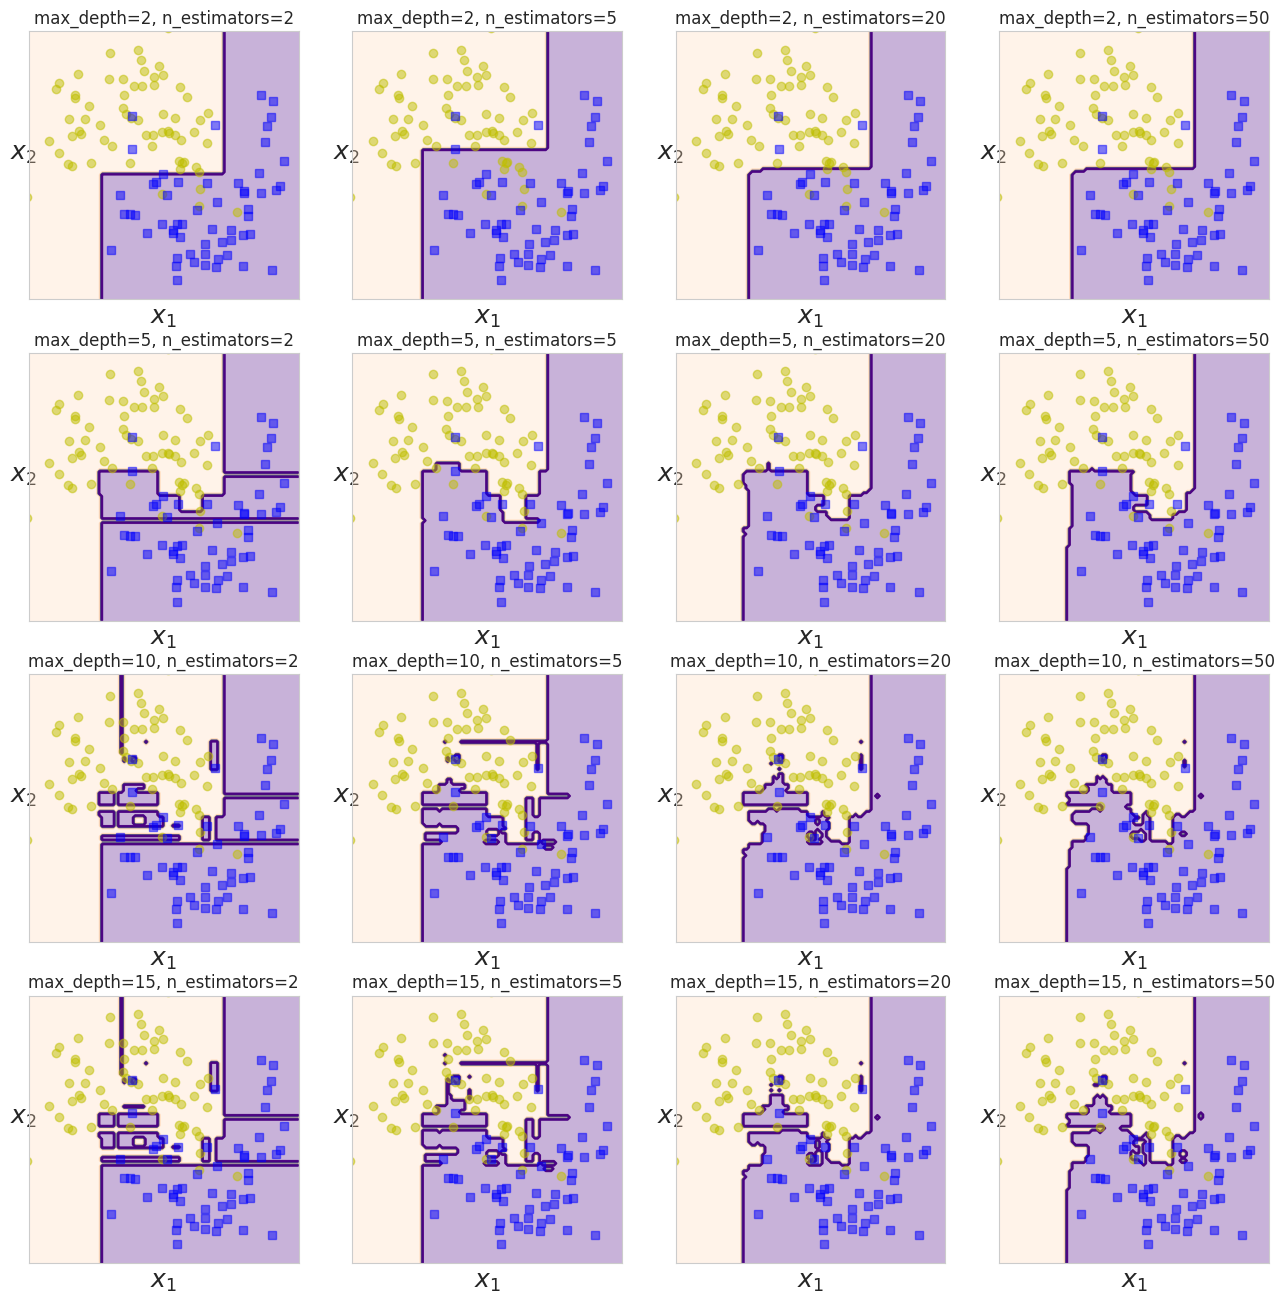

<Figure size 1000x1000 with 0 Axes>

In [ ]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

max_depth_s = [2, 5, 10, 15]
n_estimators_s = [2, 5, 20, 50]


plt.figure(figsize=(16,16))
i = 1
for max_depth in max_depth_s:
    for n_estimators in n_estimators_s:
        my_clf = RandomForestClassifierCustom(max_depth=max_depth, max_features=2, n_estimators=n_estimators)
        my_clf.fit(X,y)
        plt.subplot(4,4,i)
        plot_decision_boundary(my_clf, X_test, y_test)
        plt.title(f'max_depth={max_depth}, n_estimators={n_estimators}')
        plt.xticks([], [])
        plt.yticks([], [])
        i += 1

plt.figure(figsize=(10,10))
plt.show()

Визуально кажется случай (max_depth=5, n_estimators=50) оптимальным. Не совсем ступенька, но ещё не голова дракона.

#### Задание 2. 3. Корреляция базовых моделей

**3 балла**

Как мы выянили на лекции, для того, чтобы bagging работал хорошо, предсказания наших моделей не должны сильно коррелировать. Для этого в случайном лесе применяются различные подходы, в том числе и RSM. Давайте посмотрим, как влияет параметр `max_features` на корреляцию базовых моделей в случайном лесу из `sklearn`. В качестве примера будем использовать датасет `breast_cancer`. Для расчета корреляций используйте приведенную ниже функцию `base_model_pair_correlation`. Для каждой модели у вас будет получаться набор значений (попарные корреляции всех деревьев), дальше можно изобразить их в виде боксплотов, как мы на лекции рисовали распределение метрик.

In [ ]:
# Функция для расчета попарных корреляций базовых моделей в случайном лесу
def base_model_pair_correlation(ensemble, X):
    corrs = []
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        ypred_t2 = est2.predict_proba(Xj_test)[:, 1]

        corrs.append(pearsonr(ypred_t1, ypred_t2)[0])
    return np.array(corrs)

In [ ]:
# Загрузим данные
breast_cancer = datasets.load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

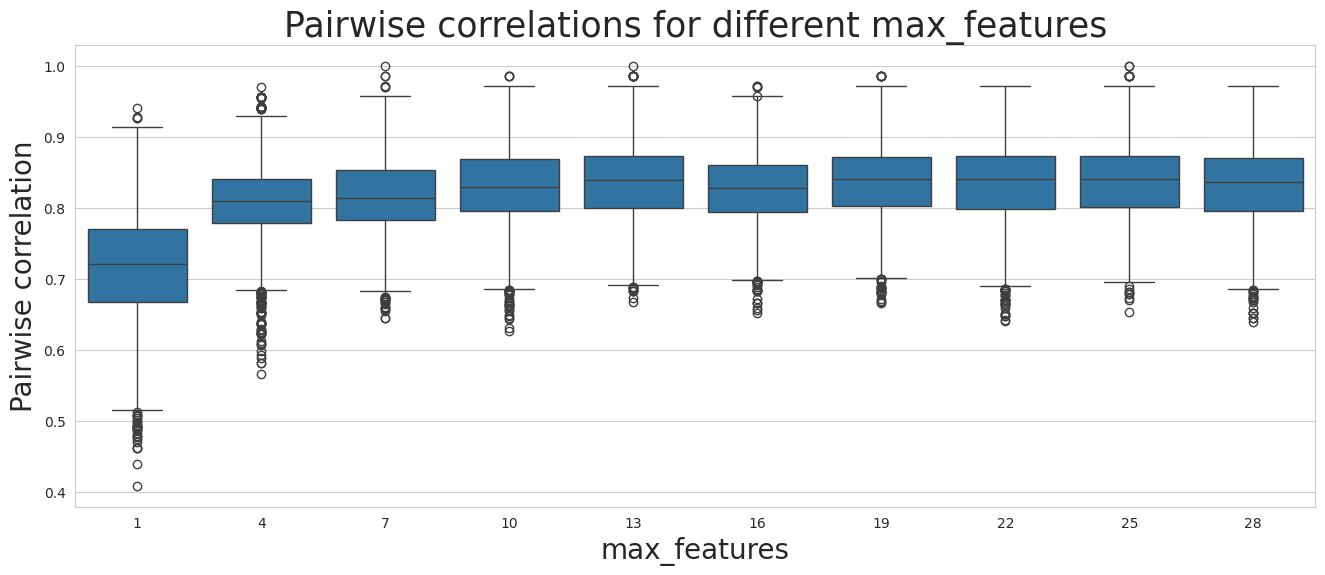

In [ ]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
res_corr = {}

for max_features in range(1, X.shape[1]+1, 3):
    clf = RandomForestClassifier( max_features=max_features, random_state=SEED)
    clf.fit(X_train, y_train)
    res_corr[max_features] = base_model_pair_correlation(clf, X_test)

cor_res = pd.DataFrame(res_corr)
cor_res = cor_res.melt(value_vars=cor_res.columns, value_name='corrs', var_name='max_features')

plt.figure(figsize=(16,6))
sns.boxplot(data=cor_res, y="corrs", x="max_features")
plt.xlabel("max_features", size=20)
plt.ylabel("Pairwise correlation", size=20)
plt.title("Pairwise correlations for different max_features", size=25)
plt.show();

Теперь давайте посмотрим, как на это влияет параметр `max_depth`:

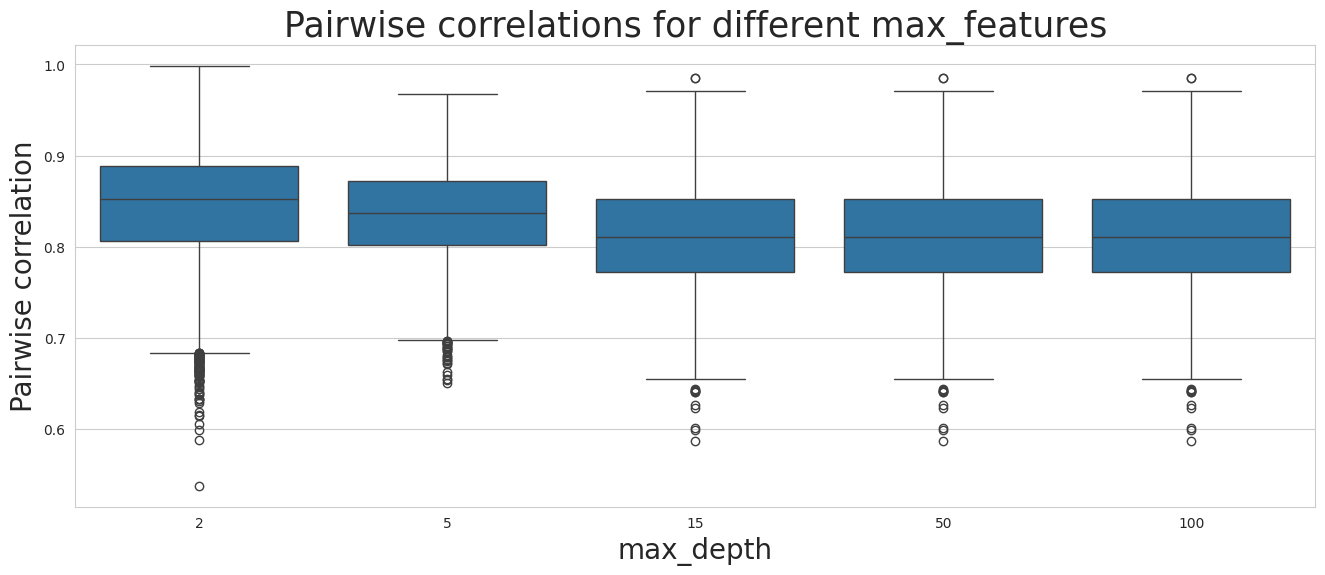

In [ ]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
res_corr = {}
max_depth_s = [2, 5, 15, 50, 100]

for max_depth in max_depth_s:
    clf = RandomForestClassifier(max_depth=max_depth, random_state=SEED)
    clf.fit(X_train, y_train)
    res_corr[max_depth] = base_model_pair_correlation(clf, X_test)

cor_res = pd.DataFrame(res_corr)
cor_res = cor_res.melt(value_vars=cor_res.columns, value_name='corrs', var_name='max_depth')

plt.figure(figsize=(16,6))
sns.boxplot(data=cor_res, y="corrs", x="max_depth")
plt.xlabel("max_depth", size=20)
plt.ylabel("Pairwise correlation", size=20)
plt.title("Pairwise correlations for different max_depth", size=25)
plt.show();

Опишите ваши наблюдения:

* Парная корреляция предсказаний отдельных моделей в зависимости от параметра max_features возрастает с его увеличением и с определённого момента выходит на насыщение (~0.8). А мы хотели, чтобы bagging работал хорошо, не очень сильную корреляцию. *но, если честно, 0,8 мне кажется многовато*

* Что касается случая параметра max_depth, для выбранных значений (от 2 до 100) не сильно меняется корреляция (~0.85)

### Задание 3. Строим большой ансамбль

**4 балла + 3 дополнительных за скор выше 0.87**

В данной задаче вам нужно диагностировать сердечное заболевание у людей по медицинским показателям.

In [54]:
#colab
#url='https://drive.google.com/file/d/11ssY2DkBkRIfPcP14G6TMAwL8XkMhmAz/view?usp=sharing'
#url='https://drive.google.com/uc?id=' + url.split('/')[-2]
#heart_dataset = pd.read_csv(url)
#heart_dataset.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [ ]:
#jup lab
heart_dataset = pd.read_csv('../data/heart.csv')

In [55]:
X = heart_dataset.drop("target", axis=1)
y = heart_dataset["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)
X_train.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
178,43,1,0,120,177,0,0,120,1,2.5,1,0,3
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3
201,60,1,0,125,258,0,0,141,1,2.8,1,1,3
246,56,0,0,134,409,0,0,150,1,1.9,1,2,3
153,66,0,2,146,278,0,0,152,0,0.0,1,1,2


Обучите разнообразные классификаторы, приведенные ниже, а также ансамбль `VotingClassifier` из `sklearn.ensemble`, объединяющий эти классификаторы с помощью жесткого или мякого голосования (параметр `voting =` `'hard'` или `'soft'` соответственно). Оцените качество моделей с помощью кросс-валидации на тренировочном наборе, используя функцию `cross_val_score` и метрику `f1`. Часть моделей отсюда мы не проходили, о них можно почитать дополнительно, но в принципе для задания не очень важно знать принципы их работы (но, если есть время, то почитайте, там интересно).

In [56]:
dt = DecisionTreeClassifier(random_state=SEED, max_depth=10, min_samples_leaf=10)
rf = RandomForestClassifier(n_estimators=50, random_state=SEED)
etc = ExtraTreesClassifier(random_state=SEED)#мета-эстиматор из RandomForestClassifier'ов. (В общем следующий уровень)
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
svc_lin = SVC(kernel='linear', probability=True, random_state=SEED)#мой любимый метод опорных векторов
svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
lgbm = lightgbm.LGBMClassifier(random_state=SEED)
lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)
xgb = xgboost.XGBClassifier(random_state=SEED)
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)
lr = LogisticRegression(solver='liblinear', max_iter=10000)
nb = GaussianNB()

base_models = [("DT", dt), ("RF", rf),
               ("ETC", etc), ("KNN", knn),
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf),
               ("CAT", cat), ("LGBM", lgbm),
               ("LGBM_RF", lgbm_rf), ("XGB", xgb),
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

Здесь могут возникать различные предупреждения при обучении бустингов, не волнуйтесь, все нормально, просто они обычно очень разговорчивые)

In [57]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
voting_hard = VotingClassifier(estimators=base_models, voting='hard')#предсказывает метку класса голосованием по правилу большинства
voting_soft = VotingClassifier(estimators=base_models, voting='soft')#предсказывает метку класса по argmax суммы прогнозируемых вероятностей
## END YOUR CODE HERE ##

res = {}#давайте добавим, чтобы вывести без варнингов и проще смотреть

#чутка переписала цикл, чтобы потом вывести без варнингов норм посмотреть результаты
for model in [dt, rf, cat, etc, knn, svc_lin, svc_rbf, xgb, lgbm, xgb_rf, lgbm_rf, lr, nb, voting_hard, voting_soft]:
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    model_name = model.__class__.__name__
    mean_score = scores.mean()

    if model_name == 'SVC':
        model_name += '_' + str(model.kernel)
    elif model_name == 'LGBMClassifier':
        model_name += '_' + str(model.boosting_type)
    elif model_name == 'VotingClassifier':
        model_name += '_' + str(model.voting)

    print(f"{model_name}: {mean_score}")
    res[model_name] = mean_score

DecisionTreeClassifier: 0.797997226792219
RandomForestClassifier: 0.8328751280279528
CatBoostClassifier: 0.8342715174922052
ExtraTreesClassifier: 0.828174603174603
KNeighborsClassifier: 0.6493313763861709
SVC_linear: 0.8403098469098905
SVC_rbf: 0.6973119072190279
XGBClassifier: 0.8134522115571786
[LightGBM] [Info] Number of positive: 79, number of negative: 72
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 190
[LightGBM] [Info] Number of data points in the train set: 151, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.523179 -> initscore=0.092782
[LightGBM] [Info] Start training from score 0.092782
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

In [58]:
#посмотрим отсортированный по среднему скору
sorted(res.items(), key=lambda x:x[1], reverse=True)

[('LogisticRegression', 0.8500073681108163),
 ('XGBRFClassifier', 0.8499478840942255),
 ('VotingClassifier_hard', 0.8494440278941667),
 ('VotingClassifier_soft', 0.8455110375195781),
 ('SVC_linear', 0.8403098469098905),
 ('CatBoostClassifier', 0.8342715174922052),
 ('RandomForestClassifier', 0.8328751280279528),
 ('ExtraTreesClassifier', 0.828174603174603),
 ('LGBMClassifier_gbdt', 0.8170106316447779),
 ('GaussianNB', 0.8140676625250128),
 ('XGBClassifier', 0.8134522115571786),
 ('LGBMClassifier_rf', 0.8132478632478634),
 ('DecisionTreeClassifier', 0.797997226792219),
 ('SVC_rbf', 0.6973119072190279),
 ('KNeighborsClassifier', 0.6493313763861709)]

Вы можете заметить, что ансамбль показывает хорошее, но не лучшее качество предсказания, попробуем его улучшить. Как вы знаете, ансамбли работают лучше, когда модели, входящие в них не скоррелированы друг с другом. Определите корреляцию предсказаний базовых моделей в ансамбле на тестовом наборе данных, и удалите из ансамбля те модели, чьи предсказания будут сильнее коррелировать с остальными. Воспользуйтесь функцией `base_model_pair_correlation_for_voting_clf`. **Спойлер**: далеко не факт, что если вы удалите две модели с корреляцией 0.95, то все станет сильно лучше, здесь все будет немного сложнее. Чтобы добиться максимального качества может понадобиться долгий перебор различных комбинаций моделей. Наилучший скор, который мне удалось достичь, это 0.915, но он получен весьма странной комбинацией алгоритмов, а еще и простым перебором всех вариантов)

In [59]:
def base_model_pair_correlation_for_voting_clf(ensemble, X):
    corrs = []
    base_model_names = [f"{est.__class__.__name__}" for est in ensemble.estimators_]
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        if not isinstance(est1, SVC):
            ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t1 = est1.decision_function(Xi_test)


        if not isinstance(est2, SVC):
            ypred_t2 = est2.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t2 = est2.decision_function(Xi_test)
        corrs.append((est1, est2, pearsonr(ypred_t1, ypred_t2)[0]))


    return corrs

> **База**: просто удалим коррелированные

In [63]:
#Отбор по корреляции
#Здесь для начала немного повторим код сверху, чтобы это было перед глазами
#помним какие модели вообще есть:
base_models = [("DT", dt), ("RF", rf),
               ("ETC", etc), ("KNN", knn),
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf),
               ("CAT", cat), ("LGBM", lgbm),
               ("LGBM_RF", lgbm_rf), ("XGB", xgb),
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

#Наши воутинги:
voting_hard = VotingClassifier(estimators=base_models, voting='hard')
voting_soft = VotingClassifier(estimators=base_models, voting='soft')
#фитим их
voting_hard.fit(X_train, y_train)
voting_soft.fit(X_train, y_train)

#оценка для харда
#print('\n\n------HARD------\n')
corrs_hard = base_model_pair_correlation_for_voting_clf(voting_hard, X_test)

#оценка для софта
#print('\n\n------SOFT------\n')
corrs_soft = base_model_pair_correlation_for_voting_clf(voting_soft, X_test)

[LightGBM] [Info] Number of positive: 118, number of negative: 109
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000094 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 227, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.519824 -> initscore=0.079337
[LightGBM] [Info] Start training from score 0.079337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

In [75]:
#чтобы норм посмотреть давайте так
cor_res_df = pd.DataFrame(columns=['est1', 'est2', 'paired_cor'])
i = 0
for (est1, est2, cor) in corrs_hard:
  new_row = {'est1': est1, 'est2': est2, 'paired_cor': cor}
  cor_res_df = cor_res_df.append(new_row, ignore_index=True)


#cor_res_df
cor_res_df.sort_values(by='paired_cor', ascending=False)

,est1,est2,paired_cor
64,LGBMClassifier(random_state=111),"XGBClassifier(base_score=None, booster=None, c...",0.970839
57,<catboost.core.CatBoostClassifier object at 0x...,LGBMClassifier(random_state=111),0.955278
26,"(ExtraTreeClassifier(random_state=481767252), ...",<catboost.core.CatBoostClassifier object at 0x...,0.952720
48,"SVC(kernel='linear', probability=True, random_...","LogisticRegression(max_iter=10000, solver='lib...",0.952159
60,<catboost.core.CatBoostClassifier object at 0x...,"XGBRFClassifier(base_score=None, booster=None,...",0.945480
...,...,...,...
40,KNeighborsClassifier(weights='distance'),"LogisticRegression(max_iter=10000, solver='lib...",0.269734
33,KNeighborsClassifier(weights='distance'),"SVC(kernel='linear', probability=True, random_...",0.249790
51,"SVC(probability=True, random_state=111)",LGBMClassifier(random_state=111),0.234962
41,KNeighborsClassifier(weights='distance'),GaussianNB(),0.231372


In [80]:
#посмотрим на модели, которые коррелируют > 0.95 друг с другом
cor_res_df[cor_res_df['paired_cor'] >= 0.95]

,est1,est2,paired_cor
26,"(ExtraTreeClassifier(random_state=481767252), ...",<catboost.core.CatBoostClassifier object at 0x...,0.952720
48,"SVC(kernel='linear', probability=True, random_...","LogisticRegression(max_iter=10000, solver='lib...",0.952159
57,<catboost.core.CatBoostClassifier object at 0x...,LGBMClassifier(random_state=111),0.955278
64,LGBMClassifier(random_state=111),"XGBClassifier(base_score=None, booster=None, c...",0.970839


> **Выкинуть нельзя оставить** (запятую поставьте) *выкидываем всё*

In [84]:
#самое простое просто выкинуть все эти модели и глянуть что будет

base_models_wo_cor_1 = [("DT", dt), ("RF", rf), ("KNN", knn), ("SVC_RBF", svc_rbf),
                        ("LGBM_RF", lgbm_rf), ("XGB_RF", xgb_rf),("NB", nb)]

voting_hard_1 = VotingClassifier(estimators=base_models_wo_cor_1, voting='hard')
voting_soft_1 = VotingClassifier(estimators=base_models_wo_cor_1, voting='soft')

res_1 = {}

#чутка переписала цикл, чтобы потом вывести без варнингов норм посмотреть результаты
for model in [voting_hard_1, voting_soft_1]:
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    model_name = model.__class__.__name__ + '_' + str(model.voting)
    mean_score = scores.mean()
    print(f"{model_name}: {mean_score}")
    res_1[model_name] = mean_score

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Info] Number of positive: 79, number of negative: 72
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000074 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 190
[LightGBM] [Info] Number of data points in the train set: 151, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.523179 -> initscore=0.092782
[LightGBM] [Info] Start training from score 0.092782
[Li

In [85]:
res_1
#ожидаемо плохо. но давайте ниже попробуем подход поумнее

{'VotingClassifier_hard': 0.8424796747967479,
 'VotingClassifier_soft': 0.8364672364672364}

> **Что-то всё-таки оставим** (запятую поставьте) *выкидываем по одной из пары скоррелированных*

In [97]:
problem_models = [("ETC", "CAT"), ("SVC_LIN", "LR"), ("LGBM", "CAT"), ("LGBM", "XGB")]

In [122]:
#давайте затестим, если будем вариации по 1 из пары выкидывать:
problem_models = [("ETC", "CAT"), ("SVC_LIN", "LR"), ("LGBM", "CAT"), ("LGBM", "XGB")]#кстати ожидаемо, что линейный svm будет с линейной регрессией коррелировать)
#в общем есть расписать комбинаторику, то там останется пара вариантов
#в цикле будем определять, что выкидываем
base_models_dict = dict((x, y) for x, y in base_models)#так проще реализовывать (по крайней мере сейчас)
for i_1 in range(2):
  for i_2 in range(2):
    for i_3 in range(2):
      for i_4 in range(2):
        if i_1 != i_3:#из-за повтора "CAT" (мы не можем его выкинуть и пары ("ETC", "CAT"), но оставить в ("LGBM", "CAT"))
          continue
        elif i_3 != i_4:#из-за повтора "LGBM"
          continue
        base_models_wo_cor_2 = base_models_dict.copy()#мега-корявая реализация, я знаю
        print(f'\n\n--------------Удаляем: {problem_models[1-1][i_1]} {problem_models[2-1][i_2]} {problem_models[3-1][i_3]} {problem_models[4-1][i_4]}--------------\n')
        if ((i_1 == 1) & (i_3 == 1)) | ((i_3 == 0) & (i_4 == 0)):
          del base_models_wo_cor_2[problem_models[4-1][i_4]]
          del base_models_wo_cor_2[problem_models[2-1][i_2]]
          del base_models_wo_cor_2[problem_models[1-1][i_1]]
        else:
          del base_models_wo_cor_2[problem_models[4-1][i_4]]
          del base_models_wo_cor_2[problem_models[3-1][i_3]]
          del base_models_wo_cor_2[problem_models[2-1][i_2]]
          del base_models_wo_cor_2[problem_models[1-1][i_1]]
        base_models_wo_cor_2 = list(base_models_wo_cor_2.items())
        voting_hard_2 = VotingClassifier(estimators=base_models_wo_cor_2, voting='hard')
        voting_soft_2 = VotingClassifier(estimators=base_models_wo_cor_2, voting='soft')

        res_2 = {}

        #чутка переписала цикл, чтобы потом вывести без варнингов норм посмотреть результаты
        for model in [voting_hard_2, voting_soft_2]:
            scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
            model_name = model.__class__.__name__ + '_' + str(model.voting)
            mean_score = scores.mean()
            print(f"{model_name}: {mean_score}")
            res_2[model_name] = mean_score
        print('\n\n--------------------------\n')
        print(res_2)
        #код прям "я у мамы программист"









--------------Удаляем: ETC SVC_LIN LGBM LGBM--------------

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Info] Number of positive: 79, number of negative: 72
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000075 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 190
[LightGBM] [Info] Number of data points in the train set: 151, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.523179 -> initscore=0.0

> ну выше не поднимается пока

> **Последняя гениальная мысль** *посмотрим именно ошибки предсказаний и по ним выкинем.*

In [125]:
#в общем это просто интересно, что если скоррелировать именно там, где ошибаются модели и на основе этого выкинуть их
#придётся переписать (тупо считать сколько одинаковых ошибок допустили):
def base_model_count_mistakes_for_voting_clf(ensemble, X, y):
    counts = []
    base_model_names = [f"{est.__class__.__name__}" for est in ensemble.estimators_]
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        c = 0
        Xi_test = X
        Xj_test = X

        if not isinstance(est1, SVC):
            ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t1 = est1.decision_function(Xi_test)


        if not isinstance(est2, SVC):
            ypred_t2 = est2.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t2 = est2.decision_function(Xi_test)

        for i in range(len(ypred_t1)):
          if (ypred_t1[i] != y[i]) & (ypred_t2[i] != y[i]):
            c += 1



        counts.append((est1, est2, c))


    return counts

Так ладно. не получилось

In [126]:
base_models = [("DT", dt), ("RF", rf),
               ("ETC", etc), ("KNN", knn),
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf),
               ("CAT", cat), ("LGBM", lgbm),
               ("LGBM_RF", lgbm_rf), ("XGB", xgb),
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

#Наши воутинги:
voting_hard = VotingClassifier(estimators=base_models, voting='hard')
voting_soft = VotingClassifier(estimators=base_models, voting='soft')
#фитим их
voting_hard.fit(X_train, y_train)
voting_soft.fit(X_train, y_train)

#оценка для харда
#print('\n\n------HARD------\n')
corrs_hard = base_model_count_mistakes_for_voting_clf(voting_hard, X_test, y_test)

#оценка для софта
#print('\n\n------SOFT------\n')
corrs_soft = base_model_count_mistakes_for_voting_clf(voting_soft, X_test, y_test)

[LightGBM] [Info] Number of positive: 118, number of negative: 109
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000093 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 227, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.519824 -> initscore=0.079337
[LightGBM] [Info] Start training from score 0.079337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

KeyError: 1

In [ ]:
#чтобы норм посмотреть давайте так
count_res_df = pd.DataFrame(columns=['est1', 'est2', 'paired_count'])
i = 0
for (est1, est2, cor) in corrs_hard:
  new_row = {'est1': est1, 'est2': est2, 'paired_count': count}
  count_res_df = count_res_df.append(new_row, ignore_index=True)


#cor_res_df
cor_res_df.sort_values(by='paired_cor', ascending=False)

### Задание 4. Определение оттока клиентов из телекома

**6 баллов + 7 дополнительных за высокое качество модели и различные эксперименты**

Будем предсказывать, уйдет ли от нас клиент (переменная `Churn?`). Данные можно скачать [здесь](https://www.kaggle.com/venky12347/churn-telecom). Это будет уже совсем взрослое задание, так как правильного ответа на него нет. Вам нужно будет разобраться с данными, правильно подготовить их для моделей, а также выбрать лучшую модель.

Задача минимум:

Выберите 2 модели &mdash; один случайный лес и один бустинг из приведенных ниже:

1. `xgboost.XGBClassifier`
2. `xgboost.XGBRFClassifier` &mdash; случайный лес от xgboost
3. `lightgbm.LGBMClassifier`
4. `lightgbm.LGBMClassifier(boosting_type="rf")` &mdash; случайный лес от lightgbm
5. `catboost.CatBoostClassifier`

И попробуйте разобраться с тем, как для этих моделей правильно настраивать гиперпараметры. Советую гуглить примерно следующее `how to choose best hyperparameters for lightgbm`. Там вы найдете кучу сложного и непонятного кода, но если с ним разобраться и научиться обучать нестандартные бустинги, то в плане табличных данных равных вам не будет)

>качала [тут](https://www.kaggle.com/datasets/venky12347/churn-telecom)

In [4]:
#colab
url='https://drive.google.com/file/d/13C0pdMXwMJ-uncteGu5w4d_LSizy3d-s/view?usp=sharing'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
data = pd.read_csv(url)
data.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


In [ ]:
#data = pd.read_csv("../data/churn.csv")
#data.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


> **EDA**

In [5]:
#сколько чего
print(f'Строк {data.shape[0]} и колонок {data.shape[1]}')

Строк 3333 и колонок 21


In [6]:
#Изучим датафрейм
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   State           3333 non-null   object 
 1   Account Length  3333 non-null   int64  
 2   Area Code       3333 non-null   int64  
 3   Phone           3333 non-null   object 
 4   Int'l Plan      3333 non-null   object 
 5   VMail Plan      3333 non-null   object 
 6   VMail Message   3333 non-null   int64  
 7   Day Mins        3333 non-null   float64
 8   Day Calls       3333 non-null   int64  
 9   Day Charge      3333 non-null   float64
 10  Eve Mins        3333 non-null   float64
 11  Eve Calls       3333 non-null   int64  
 12  Eve Charge      3333 non-null   float64
 13  Night Mins      3333 non-null   float64
 14  Night Calls     3333 non-null   int64  
 15  Night Charge    3333 non-null   float64
 16  Intl Mins       3333 non-null   float64
 17  Intl Calls      3333 non-null   i

In [7]:
#глянем сколько по колонкам уникальных значений
data.nunique()
#так ну категориальные здесь State, Area Code, Int'l Plan, VMail Plan, Intl Calls, CustServ Calls

State               51
Account Length     212
Area Code            3
Phone             3333
Int'l Plan           2
VMail Plan           2
VMail Message       46
Day Mins          1667
Day Calls          119
Day Charge        1667
Eve Mins          1611
Eve Calls          123
Eve Charge        1440
Night Mins        1591
Night Calls        120
Night Charge       933
Intl Mins          162
Intl Calls          21
Intl Charge        162
CustServ Calls      10
Churn?               2
dtype: int64

In [8]:
#давайте перекодируем no/yes, ну и Churn тоже:
data = data.replace({"Int'l Plan": {'no': 0, 'yes': 1},
                    "VMail Plan": {'no': 0, 'yes': 1},
                    "Churn?": {'False.': 0, 'True.': 1}})#пожалуйста, скажите что точки в конце булевых это не норм, мне уже страшно от этого

data.head(3)

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,0,1,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,OH,107,415,371-7191,0,1,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,NJ,137,415,358-1921,0,0,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0


In [9]:
#Краткая сводка
data.describe()
#данные не стандартизированы, но нам это и не нужно пока

,Account Length,Area Code,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,0.096910,0.276628,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856,0.144914
std,39.822106,42.371290,0.295879,0.447398,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491,0.352067
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,0.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000,0.000000
50%,101.000000,415.000000,0.000000,0.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000,0.000000
75%,127.000000,510.000000,0.000000,1.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000,0.000000
max,243.000000,510.000000,1.000000,1.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000,1.000000


In [10]:
#Кол-во NA
print(f'Количество NA: {(data.isnull().sum()).sum()}')
#Дубликаты
print(f'Количество дубликатов: {(data[data.duplicated()]).shape[0]}')
#Тут всё хорошо, ничего чистить и править не надо

Количество NA: 0
Количество дубликатов: 0


In [11]:
#что по балансу
data['Churn?'].value_counts()
#не сбалансированы классы 2850/483~6

0    2850
1     483
Name: Churn?, dtype: int64

In [12]:
#давайте сразу дропнем Phone, т.к. смысловой нагрузки в нём нет (см ниже пояснения)
data = data.drop(['Phone'], axis=1)
data.head(3)

,State,Account Length,Area Code,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,OH,107,415,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,NJ,137,415,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0


----------Area Code----------


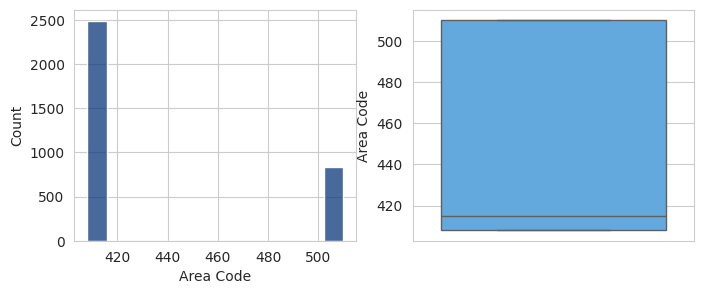

----------Int'l Plan----------


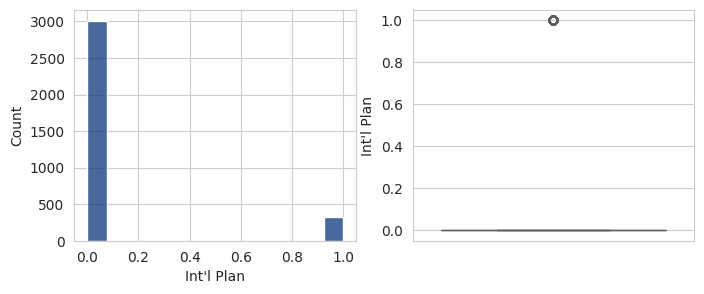

----------VMail Plan----------


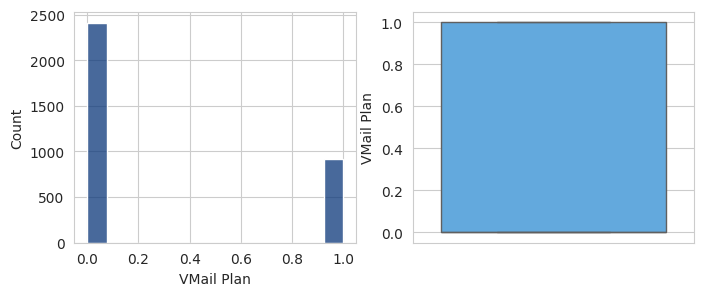

----------VMail Message----------


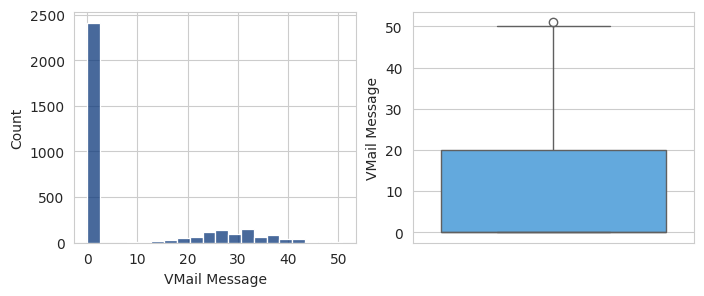

----------Day Mins----------


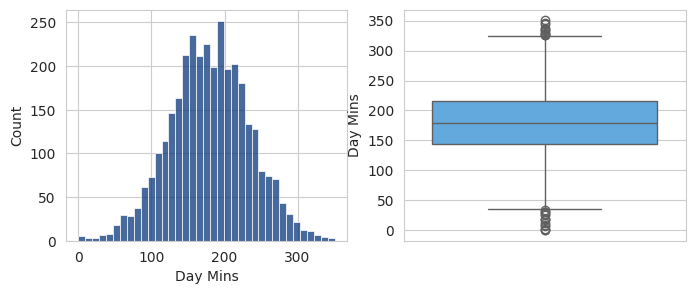

----------Day Calls----------


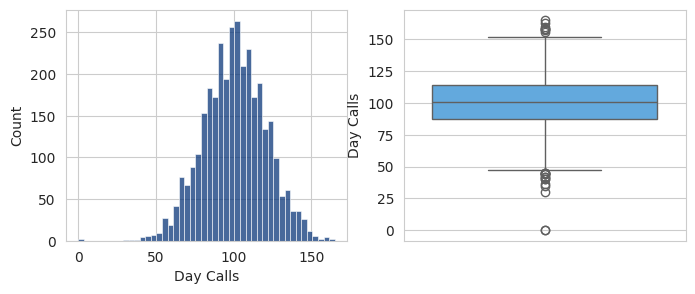

----------Day Charge----------


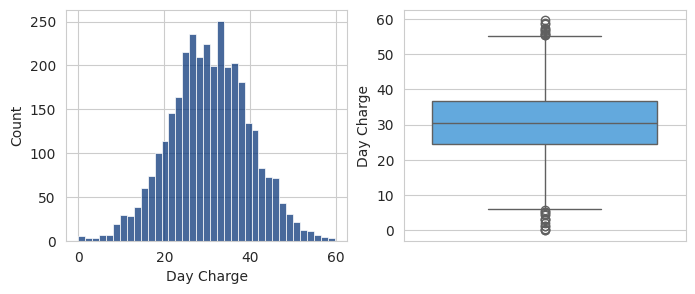

----------Eve Mins----------


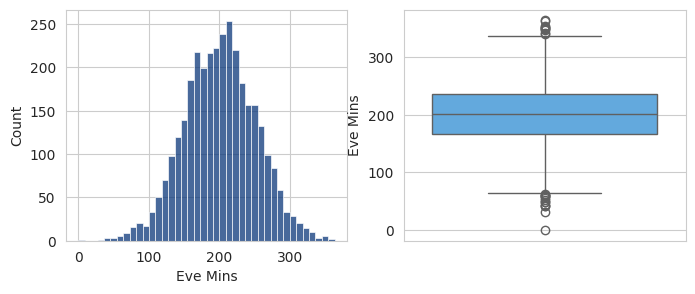

----------Eve Calls----------


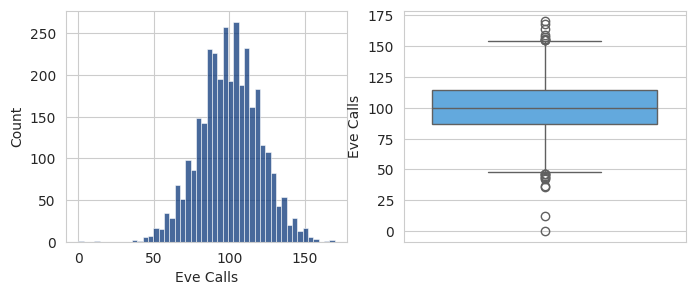

----------Eve Charge----------


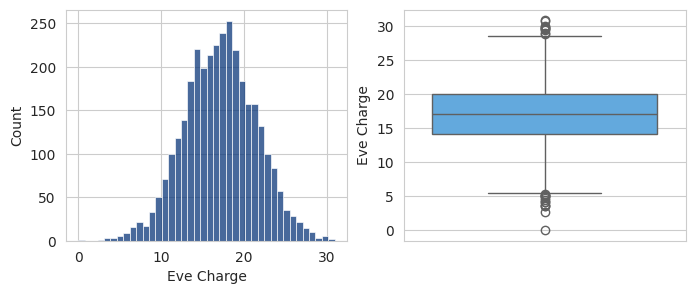

----------Night Mins----------


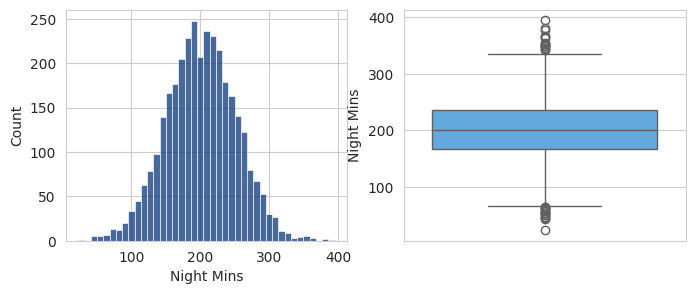

----------Night Calls----------


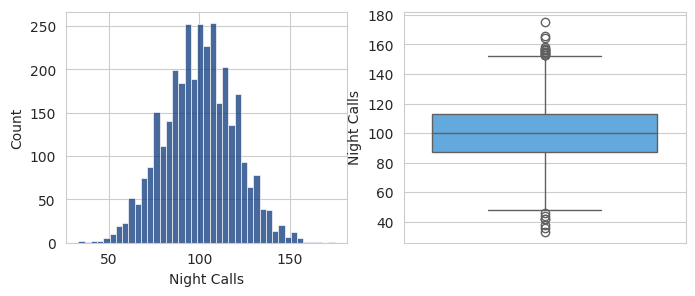

----------Night Charge----------


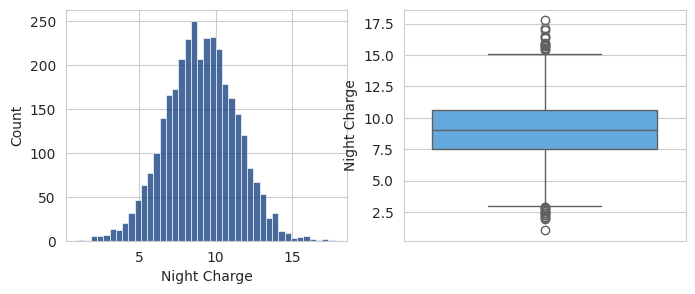

----------Intl Mins----------


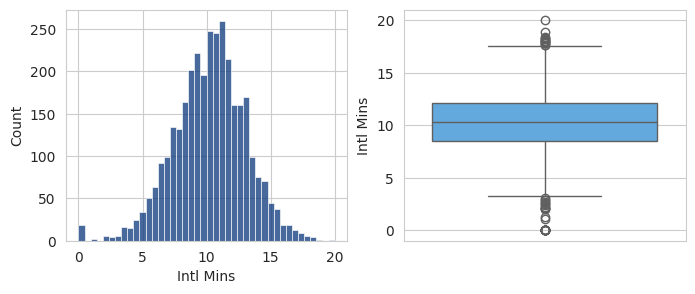

----------Intl Calls----------


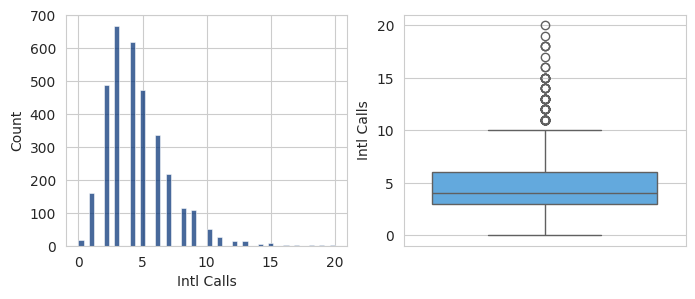

----------Intl Charge----------


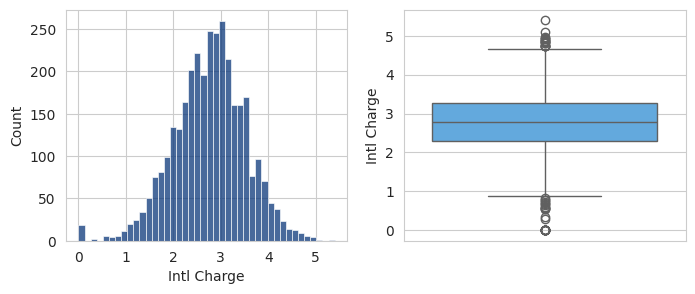

----------CustServ Calls----------


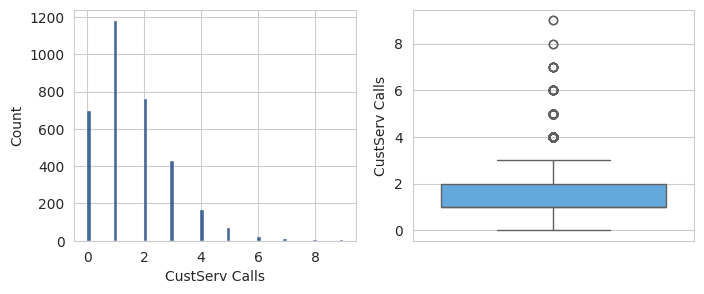

----------Churn?----------


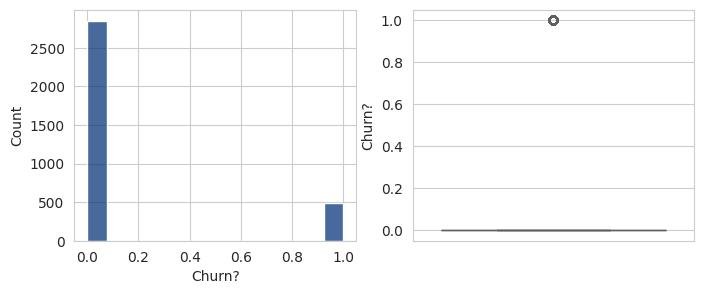

In [13]:
#повизуализируем: давайте глянем боксплоты и гистограммки
for i in range(2, len(data.columns)):
    print(f'----------{data.columns[i]}----------')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
    sns.histplot(data.iloc[:, i], ax=ax1, color='#0a377a')
    sns.boxplot(data.iloc[:, i], ax=ax2, color='#4facf1')
    plt.show()
#так ну здесь от выбросов чистить не будем. Есть странненькое у Intl Calls, но там не совсем отдельные точки. Оставим в общем всё

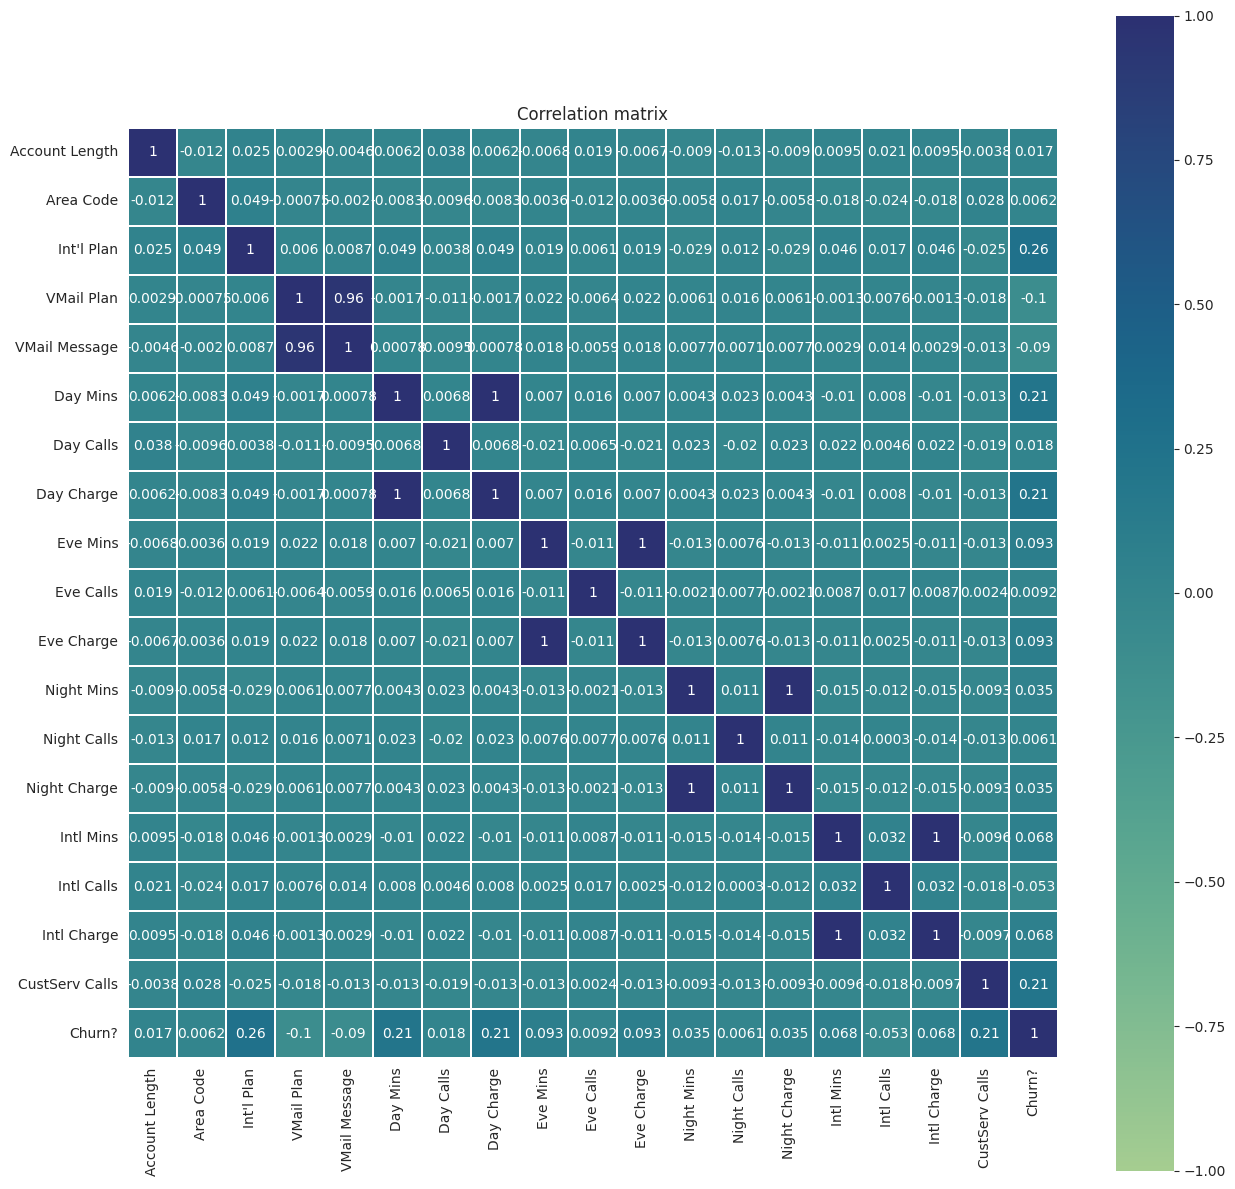

In [14]:
#корреляции
correlations = data.drop(['State'], axis=1).corr()#выкинеме единственный не численный признак

plt.figure(figsize=(15,15))
sns.heatmap(correlations, square=True, annot=True, linewidths=0.25, vmin=-1, vmax=1, cmap="crest")
plt.title("Correlation matrix")
plt.show();
#так, ну есть фичи, которые прям совсем скореллирован (> 0.95)

>Итого предлагаю выбросить следующее:
>* Phone - потому что вряд ли кто-то из клиентов ушёл из-за своего номер, хотя если хотелось красивый типа 777-7777, а дали 382-4657, то, наверное, понять можно (его дропали выше).
>* Area Code - это как бы тоже часть номера. Хотя, конечно, можно притянуть, что это кодирует географические области и в зависимости от области клиенты могут вести себя по-разному. Но пока усложнять не будем. Начнём с простого. Тем более у нас есть State
>* Day Charge, Eve Charge, Night Charge, Intl Charge - потому что у них есть братья-корреляты
>* По поводу State его бы закодировать ванхотэнкодером, но тогда будет +51 фича. Давайте пока его дропнем тоже]

In [15]:
#давайте выбросим State,Area Code,Phone. Они кажутся бессмысленнми
df = data.drop(['Area Code',  'Day Charge', 'Eve Charge', 'Night Charge', 'Intl Charge', 'State'], axis=1)
df.head(3)

,Account Length,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Eve Mins,Eve Calls,Night Mins,Night Calls,Intl Mins,Intl Calls,CustServ Calls,Churn?
0,128,0,1,25,265.1,110,197.4,99,244.7,91,10.0,3,1,0
1,107,0,1,26,161.6,123,195.5,103,254.4,103,13.7,3,1,0
2,137,0,0,0,243.4,114,121.2,110,162.6,104,12.2,5,0,0


In [16]:
#Подведём итог:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Account Length  3333 non-null   int64  
 1   Int'l Plan      3333 non-null   int64  
 2   VMail Plan      3333 non-null   int64  
 3   VMail Message   3333 non-null   int64  
 4   Day Mins        3333 non-null   float64
 5   Day Calls       3333 non-null   int64  
 6   Eve Mins        3333 non-null   float64
 7   Eve Calls       3333 non-null   int64  
 8   Night Mins      3333 non-null   float64
 9   Night Calls     3333 non-null   int64  
 10  Intl Mins       3333 non-null   float64
 11  Intl Calls      3333 non-null   int64  
 12  CustServ Calls  3333 non-null   int64  
 13  Churn?          3333 non-null   int64  
dtypes: float64(4), int64(10)
memory usage: 364.7 KB


> **Приступаем к моделям**

In [17]:
X = df.drop(['Churn?'], axis=1)
y = df['Churn?']

In [18]:
X

,Account Length,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Eve Mins,Eve Calls,Night Mins,Night Calls,Intl Mins,Intl Calls,CustServ Calls
0,128,0,1,25,265.1,110,197.4,99,244.7,91,10.0,3,1
1,107,0,1,26,161.6,123,195.5,103,254.4,103,13.7,3,1
2,137,0,0,0,243.4,114,121.2,110,162.6,104,12.2,5,0
3,84,1,0,0,299.4,71,61.9,88,196.9,89,6.6,7,2
4,75,1,0,0,166.7,113,148.3,122,186.9,121,10.1,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,192,0,1,36,156.2,77,215.5,126,279.1,83,9.9,6,2
3329,68,0,0,0,231.1,57,153.4,55,191.3,123,9.6,4,3
3330,28,0,0,0,180.8,109,288.8,58,191.9,91,14.1,6,2
3331,184,1,0,0,213.8,105,159.6,84,139.2,137,5.0,10,2


In [19]:
y

0       0
1       0
2       0
3       0
4       0
       ..
3328    0
3329    0
3330    0
3331    0
3332    0
Name: Churn?, Length: 3333, dtype: int64

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

> **xgboost.XGBClassifier**

F1 score = 0.7962085308056872
Коэффициент корреляции Мэтьюса = 0.7731191666082187


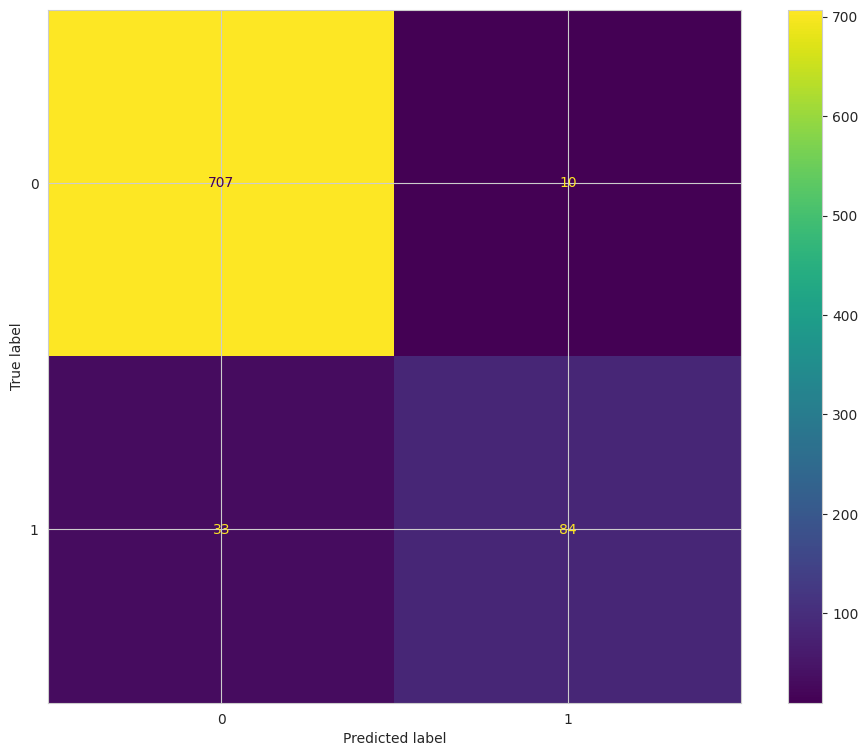

In [ ]:
#давайте сначала просто хотя бы запустим это на наших данных (так скажем, начнём с бейзлайна)
xgb = xgboost.XGBClassifier(random_state=SEED)#default: max_depth=3. learning_rate=0.1. n_estimators=100. silent=True, gamma=0
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

#предлагаю пока чекать по confusion matrix (для интереса) и f1-скору
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_xgb)).plot()
print(f'F1 score = {f1_score(y_test, y_pred_xgb)}')
#а вообще на консультации мы обсудили коэффициент корреляции Мэтьюса для случая дисбаланса классов. Давайте затестим:
print(f'Коэффициент корреляции Мэтьюса = {matthews_corrcoef(y_test, y_pred_xgb)}')

In [ ]:
%%time
#теперь поподбираем
xgb = xgboost.XGBClassifier()
space_xgb = {
    'max_depth': [3, 4, 6, 10, 12],
    'n_estimators': [10, 50, 100],
    'learning_rate': [0, 0.01, 0.3, 0.8, 1],
    'gamma': [0, 0.01, 0.3, 0.8, 5],
    'eta': [0, 0.01, 0.3, 0.8, 1],
    'random_state': [SEED]
}
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=space_xgb,
    scoring='f1',
    n_jobs=-1,
    cv=5,
    verbose=1
)
grid_search.fit(X_train, y_train)

print('----------')
print(grid_search.best_params_)

Fitting 5 folds for each of 1875 candidates, totalling 9375 fits
----------
{'eta': 0, 'gamma': 0.3, 'learning_rate': 0.3, 'max_depth': 4, 'n_estimators': 50, 'random_state': 111}
CPU times: user 11.9 s, sys: 1.48 s, total: 13.4 s
Wall time: 2min 7s


F1 score = 0.8038277511961722
Коэффициент корреляции Мэтьюса = 0.7835157391162008


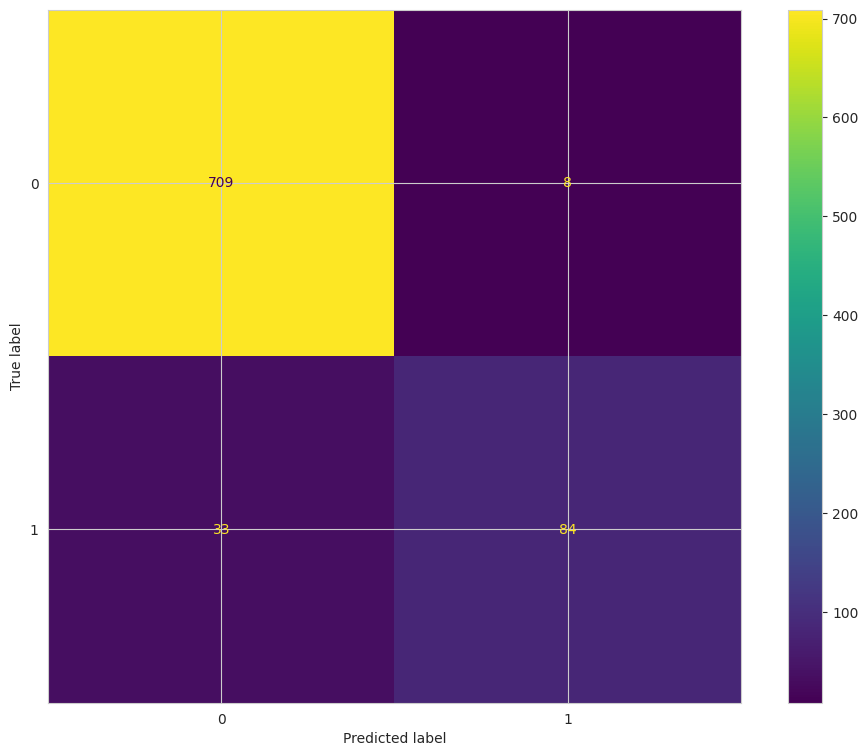

In [ ]:
#лучшая
xgb_best = xgboost.XGBClassifier(eta=0, gamma=0.3, learning_rate=0.3, max_depth=4, n_estimators=50, random_state=SEED)
xgb_best.fit(X_train, y_train)
y_pred_xgb_best = xgb_best.predict(X_test)

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_xgb_best)).plot()
print(f'F1 score = {f1_score(y_test, y_pred_xgb_best)}')
print(f'Коэффициент корреляции Мэтьюса = {matthews_corrcoef(y_test, y_pred_xgb_best)}')

>*Ура, мы улучшили скор, но не на очень много конечно.*

ссылочки для себя: [A Guide on XGBoost hyperparameters tuning](https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning)

> **xgboost.XGBRFClassifier**

F1 score = 0.7772511848341233
Коэффициент корреляции Мэтьюса = 0.7512836359450993


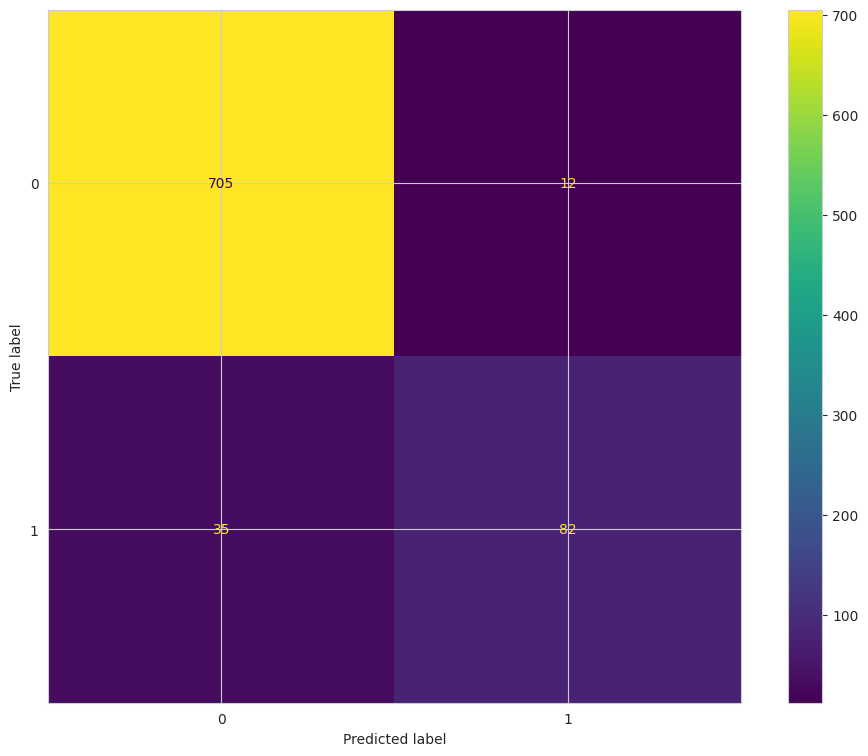

In [ ]:
#база
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)
xgb_rf.fit(X_train, y_train)
y_pred_xgb_rf = xgb_rf.predict(X_test)

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_xgb_rf)).plot()
print(f'F1 score = {f1_score(y_test, y_pred_xgb_rf)}')
print(f'Коэффициент корреляции Мэтьюса = {matthews_corrcoef(y_test, y_pred_xgb_rf)}')

In [ ]:
%%time
#теперь поподбираем
xgb_rf = xgboost.XGBRFClassifier()
space_xgb_rf = {
    'max_depth': [3, 4, 6, 10, 12],
    'n_estimators': [10, 50, 100],
    'learning_rate': [0, 0.01, 0.3, 0.8, 1],
    'gamma': [0, 0.01, 0.3, 0.8, 5],
    'eta': [0, 0.01, 0.3, 0.8, 1],
    'random_state': [SEED]
}
grid_search = GridSearchCV(
    estimator=xgb_rf,
    param_grid=space_xgb_rf,
    scoring='f1',
    n_jobs=-1,
    cv=5,
    verbose=1
)
grid_search.fit(X_train, y_train)

print('----------')
print(grid_search.best_params_)

Fitting 5 folds for each of 1875 candidates, totalling 9375 fits
----------
{'eta': 0, 'gamma': 0.01, 'learning_rate': 0.8, 'max_depth': 12, 'n_estimators': 50, 'random_state': 111}
CPU times: user 17.5 s, sys: 3.38 s, total: 20.8 s
Wall time: 3min 9s


F1 score = 0.7641509433962265
Коэффициент корреляции Мэтьюса = 0.7354324348123983


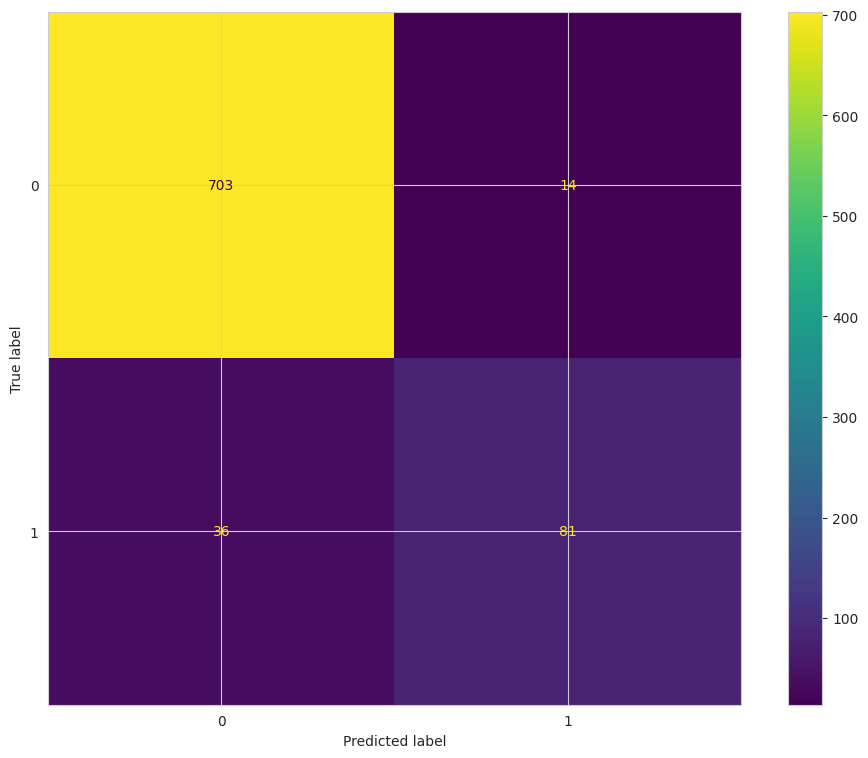

In [ ]:
#лучшая
xgb_rf_best = xgboost.XGBRFClassifier(eta=0, gamma=0.01, learning_rate=0.8, max_depth=12, n_estimators=50, random_state=SEED)
xgb_rf_best.fit(X_train, y_train)
y_pred_xgb_rf_best = xgb_rf_best.predict(X_test)

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_xgb_rf_best)).plot()
print(f'F1 score = {f1_score(y_test, y_pred_xgb_rf_best)}')
print(f'Коэффициент корреляции Мэтьюса = {matthews_corrcoef(y_test, y_pred_xgb_rf_best)}')

> стало хуже...

> **lightgbm.LGBMClassifier**

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 366, number of negative: 2133
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000624 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1470
[LightGBM] [Info] Number of data points in the train set: 2499, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.146459 -> initscore=-1.762651
[LightGBM] [Info] Start training from score -1.762651
F1 score = 0.8372093023255814
Коэффициент корреляции Мэтьюса = 0.8175450414585541


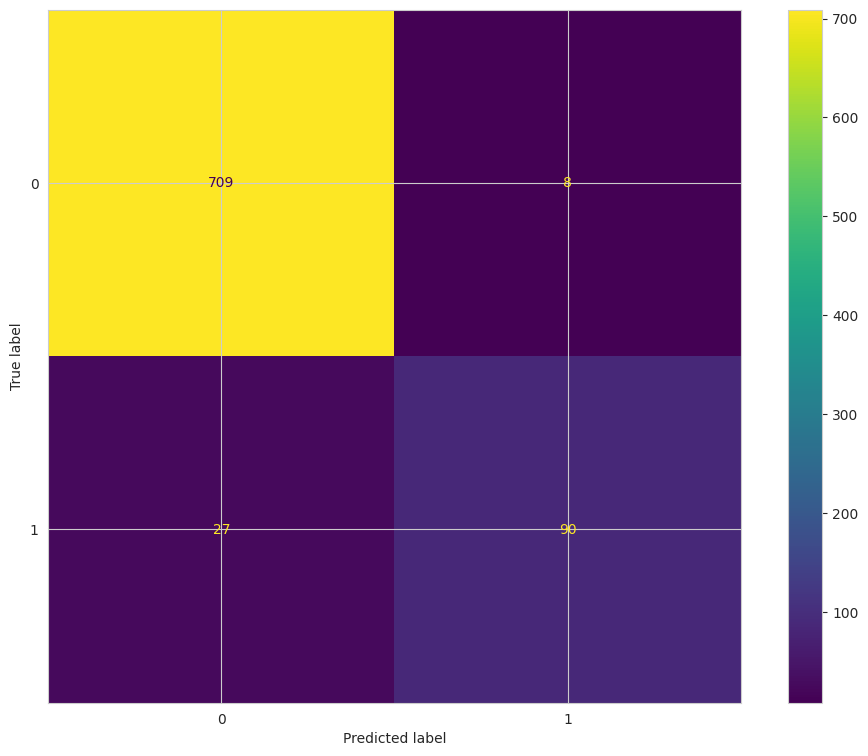

In [21]:
#база
lgbm = lightgbm.LGBMClassifier(random_state=SEED)
lgbm.fit(X_train, y_train)
y_pred_lgbm = lgbm.predict(X_test)

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_lgbm)).plot()
print(f'F1 score = {f1_score(y_test, y_pred_lgbm)}')
print(f'Коэффициент корреляции Мэтьюса = {matthews_corrcoef(y_test, y_pred_lgbm)}')

In [22]:
%%time
#теперь поподбираем
lgbm = lightgbm.LGBMClassifier()
space_lgbm = {
    'num_leaves': [30, 12, 8, 4, 3],#нужно уменьшать 2^max_depth
    'max_depth': [12, 10, 6, 4, 3],#нужно уменьшать,
    'min_data_in_leaf': [30, 100, 300, 1000],#нужно увеличивать
    #'n_estimators': [10, 50, 100],
    'learning_rate': [0.01, 0.5, 1],
    'random_state': [SEED]
}
grid_search = GridSearchCV(
    estimator=lgbm,
    param_grid=space_lgbm,
    scoring='f1',
    n_jobs=-1,
    cv=5,
    verbose=1
)
grid_search.fit(X_train, y_train)

print('----------')
print(grid_search.best_params_)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Info] Number of positive: 366, number of negative: 2133
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000490 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1470
[LightGBM] [Info] Number of data points in the train set: 2499, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.146459 -> initscore=-1.762651
[LightGBM] [Info] Start training from score -1.762651
----------
{'learning_rate': 0.5, 'max_depth': 12, 'min_data_in_leaf': 30, 'num_leaves': 12, 'random_state': 111}
CPU time

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Info] Number of positive: 366, number of negative: 2133
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000375 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1470
[LightGBM] [Info] Number of data points in the train set: 2499, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.146459 -> initscore=-1.762651
[LightGBM] [Info] Start training from score -1.762651
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


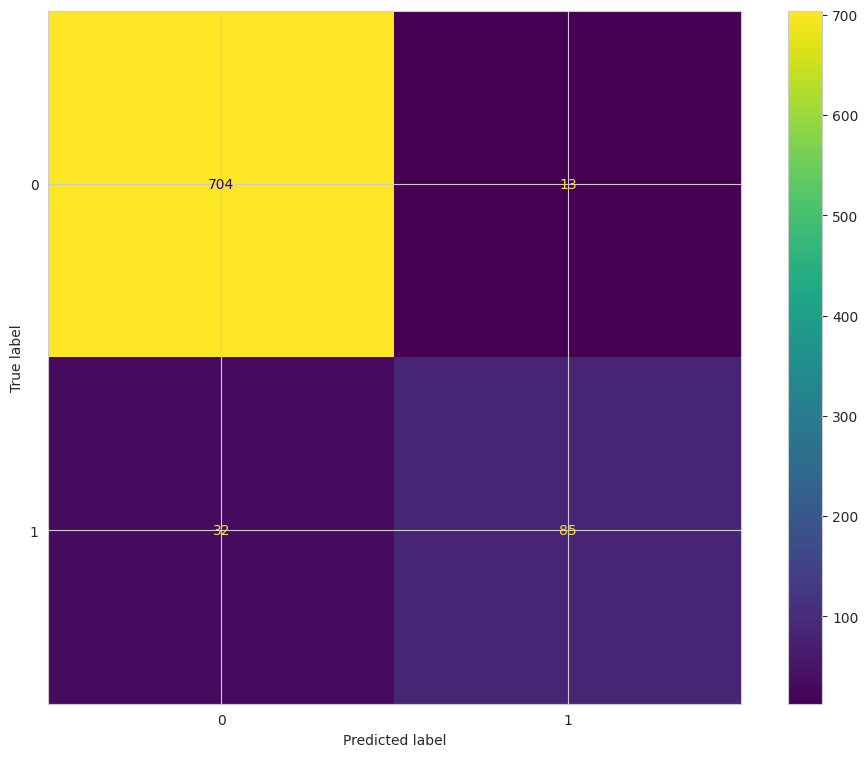

In [31]:
#лучшая
lgbm_best = lightgbm.LGBMClassifier(learning_rate=0.5, max_depth=12, min_data_in_leaf=30, num_leaves=12, random_state=SEED)
lgbm_best.fit(X_train, y_train)
y_pred_lgbm_best = lgbm_best.predict(X_test)

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_lgbm_best)).plot()
print(f'F1 score = {f1_score(y_test, y_pred_lgbm_best)}')
print(f'Коэффициент корреляции Мэтьюса = {matthews_corrcoef(y_test, y_pred_lgbm_best)}')

> тоже не получилось...(но видимо разбираться с этим буду уже после ИБ)


ссылочки для себя: [Understanding LightGBM Parameters (and How to Tune Them)](https://neptune.ai/blog/lightgbm-parameters-guide);
[Cross-validation and Hyperparameter tuning of LightGBM Model](https://www.geeksforgeeks.org/cross-validation-and-hyperparameter-tuning-of-lightgbm-model/);
[Parameters Tuning](https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html);
[Tuning Hyperparameters Under 10 Minutes (LGBM)](https://www.kaggle.com/code/somang1418/tuning-hyperparameters-under-10-minutes-lgbm)

> **lightgbm.LGBMClassifier(boosting_type="rf")**

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Info] Number of positive: 366, number of negative: 2133
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1470
[LightGBM] [Info] Number of data points in the train set: 2499, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.146459 -> initscore=-1.762651
[LightGBM] [Info] Start training f

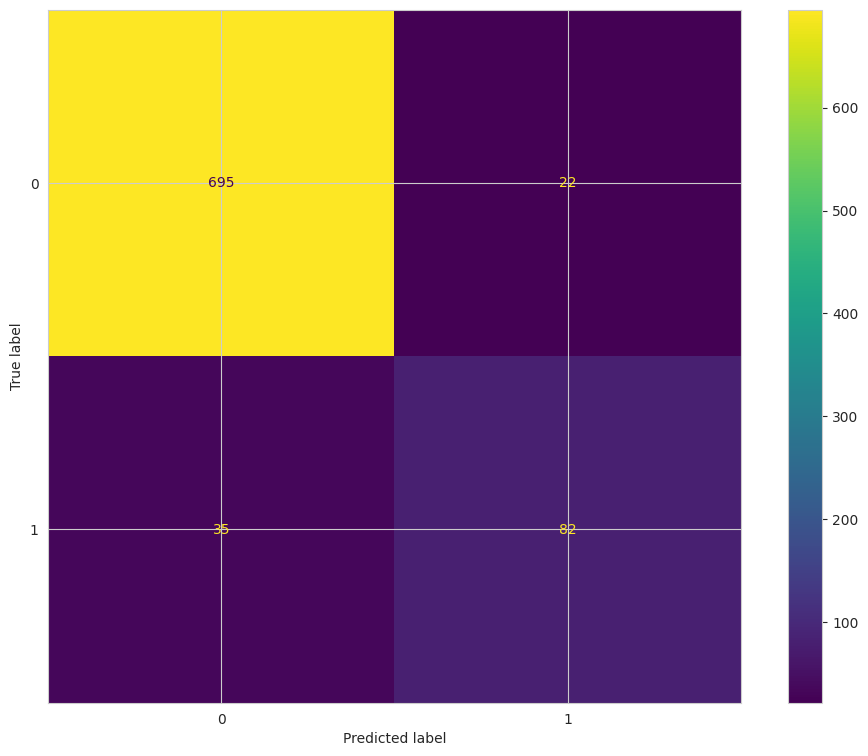

In [32]:
#база
lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)
lgbm_rf.fit(X_train, y_train)
y_pred_lgbm_rf = lgbm_rf.predict(X_test)

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_lgbm_rf)).plot()
print(f'F1 score = {f1_score(y_test, y_pred_lgbm_rf)}')
print(f'Коэффициент корреляции Мэтьюса = {matthews_corrcoef(y_test, y_pred_lgbm_rf)}')

In [33]:
%%time
#теперь поподбираем
lgbm_rf = lightgbm.LGBMClassifier()
space_lgbm_rf = {
    'num_leaves': [30, 12, 8, 4, 3],#нужно уменьшать 2^max_depth
    'max_depth': [12, 10, 6, 4, 3],#нужно уменьшать,
    'min_data_in_leaf': [30, 100, 300, 1000],#нужно увеличивать
    #'n_estimators': [10, 50, 100],
    'learning_rate': [0.01, 0.5, 1],
    'bagging_freq' : [1],
    'bagging_fraction': [0.7],
    'boosting_type': ["rf"],
    'random_state': [SEED]
}
grid_search = GridSearchCV(
    estimator=lgbm_rf,
    param_grid=space_lgbm_rf,
    scoring='f1',
    n_jobs=-1,
    cv=5,
    verbose=1
)
grid_search.fit(X_train, y_train)

print('----------')
print(grid_search.best_params_)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Info] Number of positive: 366, number of negative: 2133
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000342

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Info] Number of positive: 366, number of negative: 2133
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000647 seconds.
You can set `force_col_wise=true` to remove the overhe

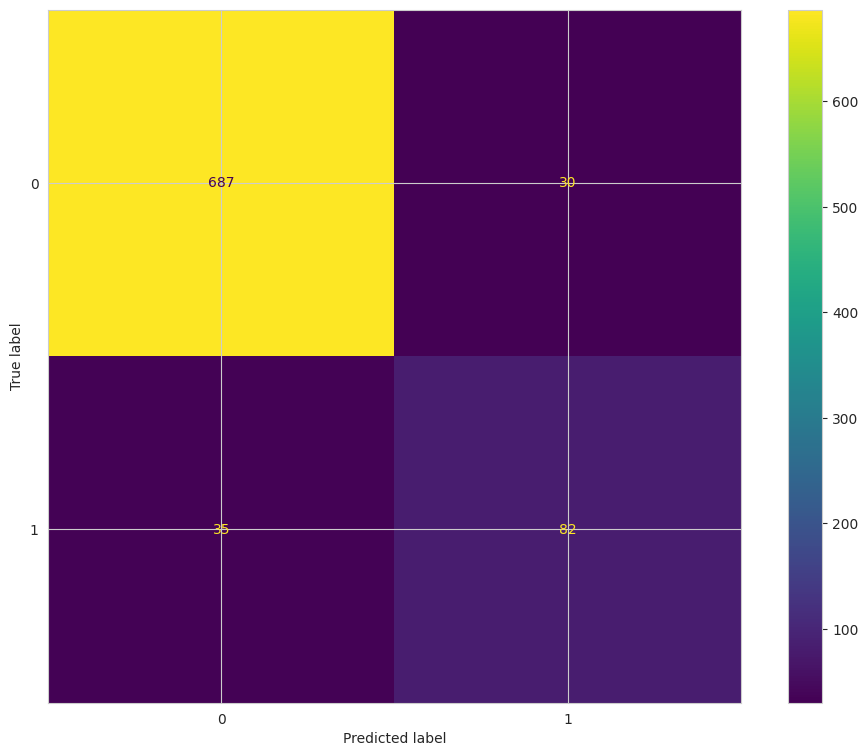

In [34]:
#лучшая
lgbm_rf_best = lightgbm.LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf', learning_rate=0.01, max_depth=6, min_data_in_leaf=30, num_leaves=30, random_state=SEED)
lgbm_rf_best.fit(X_train, y_train)
y_pred_lgbm_rf_best = lgbm_rf_best.predict(X_test)

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_lgbm_rf_best)).plot()
print(f'F1 score = {f1_score(y_test, y_pred_lgbm_rf_best)}')
print(f'Коэффициент корреляции Мэтьюса = {matthews_corrcoef(y_test, y_pred_lgbm_rf_best)}')

>no comments

> **catboost.CatBoostClassifier**

F1 score = 0.820754716981132
Коэффициент корреляции Мэтьюса = 0.8006374154782719


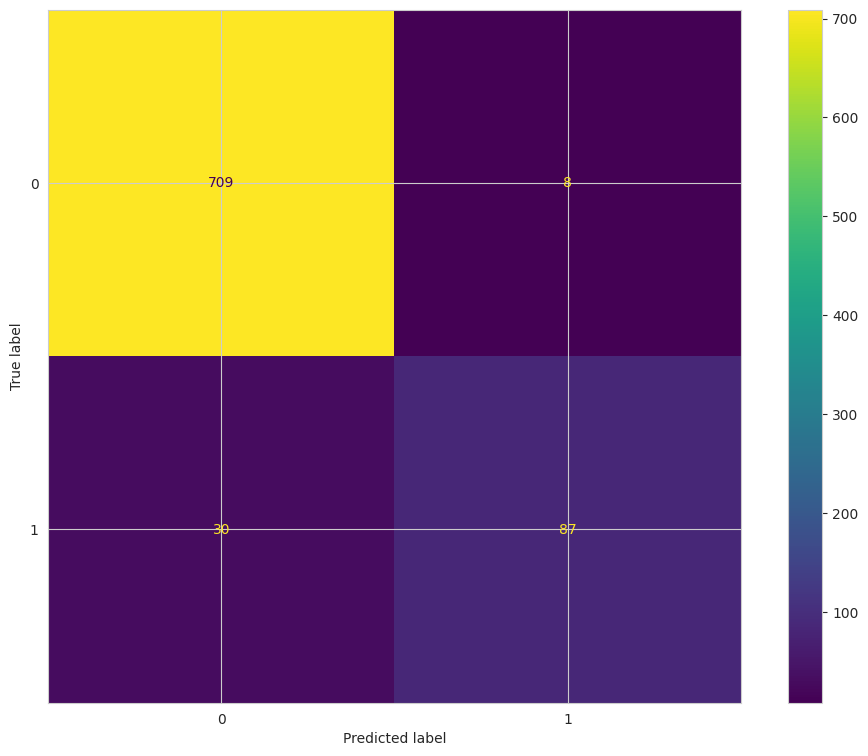

In [35]:
#база
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
cat.fit(X_train, y_train)
y_pred_cat = cat.predict(X_test)

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_cat)).plot()
print(f'F1 score = {f1_score(y_test, y_pred_cat)}')
print(f'Коэффициент корреляции Мэтьюса = {matthews_corrcoef(y_test, y_pred_cat)}')

In [24]:
%%time
#теперь поподбираем
cat = catboost.CatBoostClassifier()
space_cat = {
    'iterations': [100, 500, 1000],
    'learning_rate': [0.01, 0.1, 1],
    'depth': [6, 8, 10],
    'random_state': [SEED]
}
grid_search = GridSearchCV(
    estimator=cat,
    param_grid=space_cat,
    scoring='f1',
    n_jobs=-1,
    cv=5,
    verbose=1
)
grid_search.fit(X_train, y_train)

print('----------')
print(grid_search.best_params_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
0:	learn: 0.6096906	total: 56.5ms	remaining: 28.2s
1:	learn: 0.5365701	total: 62.7ms	remaining: 15.6s
2:	learn: 0.4741041	total: 71ms	remaining: 11.8s
3:	learn: 0.4210283	total: 78.8ms	remaining: 9.77s
4:	learn: 0.3844863	total: 86.8ms	remaining: 8.6s
5:	learn: 0.3532292	total: 94.7ms	remaining: 7.79s
6:	learn: 0.3273543	total: 103ms	remaining: 7.22s
7:	learn: 0.2989989	total: 110ms	remaining: 6.78s
8:	learn: 0.2803243	total: 118ms	remaining: 6.45s
9:	learn: 0.2737990	total: 126ms	remaining: 6.17s
10:	learn: 0.2629545	total: 134ms	remaining: 5.96s
11:	learn: 0.2509382	total: 142ms	remaining: 5.76s
12:	learn: 0.2416442	total: 150ms	remaining: 5.61s
13:	learn: 0.2316684	total: 158ms	remaining: 5.47s
14:	learn: 0.2234792	total: 166ms	remaining: 5.35s
15:	learn: 0.2170574	total: 178ms	remaining: 5.39s
16:	learn: 0.2099118	total: 187ms	remaining: 5.3s
17:	learn: 0.2013085	total: 193ms	remaining: 5.17s
18:	learn: 0.1968811	total: 

0:	learn: 0.6096906	total: 2.71ms	remaining: 1.35s
1:	learn: 0.5365701	total: 13.6ms	remaining: 3.38s
2:	learn: 0.4741041	total: 20.3ms	remaining: 3.36s
3:	learn: 0.4210283	total: 28.9ms	remaining: 3.59s
4:	learn: 0.3844863	total: 37.1ms	remaining: 3.67s
5:	learn: 0.3532292	total: 45.1ms	remaining: 3.71s
6:	learn: 0.3273543	total: 53.4ms	remaining: 3.76s
7:	learn: 0.2989989	total: 61.8ms	remaining: 3.8s
8:	learn: 0.2803243	total: 69.9ms	remaining: 3.81s
9:	learn: 0.2737990	total: 80.1ms	remaining: 3.92s
10:	learn: 0.2629545	total: 86.7ms	remaining: 3.85s
11:	learn: 0.2509382	total: 95ms	remaining: 3.86s
12:	learn: 0.2416442	total: 103ms	remaining: 3.87s
13:	learn: 0.2316684	total: 111ms	remaining: 3.87s
14:	learn: 0.2234792	total: 119ms	remaining: 3.86s
15:	learn: 0.2170574	total: 128ms	remaining: 3.86s
16:	learn: 0.2099118	total: 136ms	remaining: 3.85s
17:	learn: 0.2013085	total: 144ms	remaining: 3.85s
18:	learn: 0.1968811	total: 152ms	remaining: 3.85s
19:	learn: 0.1912934	total: 162m

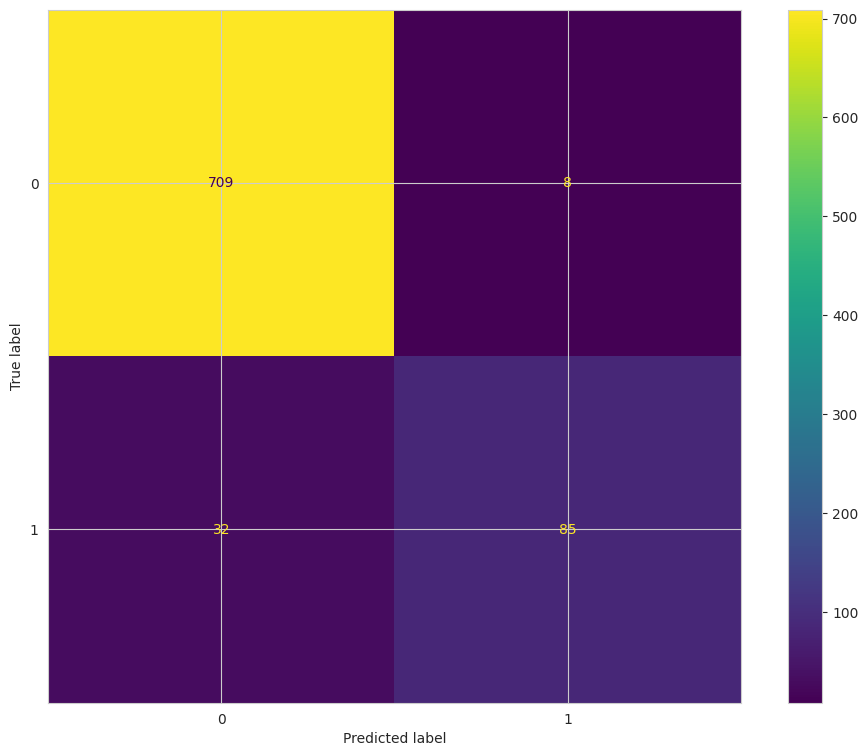

In [36]:
#лучшая
cat_best = catboost.CatBoostClassifier(depth=6, iterations=500, learning_rate=0.1, random_state=SEED)
cat_best.fit(X_train, y_train)
y_pred_cat_best = cat_best.predict(X_test)

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_cat_best)).plot()
print(f'F1 score = {f1_score(y_test, y_pred_cat_best)}')
print(f'Коэффициент корреляции Мэтьюса = {matthews_corrcoef(y_test, y_pred_cat_best)}')

> **catboost.CatBoostClassifier со State**
>
> *поскольку catboost раскрывается для категориальных признаков, давайте затестим на датафрейме с фичёй State, которая будет категориальная и которую мы ранее выкидывали:*

In [39]:
#придётся немного повторить подготовку датасета
df_cat = data.drop(['Area Code',  'Day Charge', 'Eve Charge', 'Night Charge', 'Intl Charge'], axis=1)#дропаем всё то же самое, но не State
#df_cat['State'] = df_cat['State'].astype('category')

X_cat = df_cat.drop(['Churn?'], axis=1)
y_cat = df_cat['Churn?']
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(X_cat, y_cat, random_state=SEED)
df_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   State           3333 non-null   object 
 1   Account Length  3333 non-null   int64  
 2   Int'l Plan      3333 non-null   int64  
 3   VMail Plan      3333 non-null   int64  
 4   VMail Message   3333 non-null   int64  
 5   Day Mins        3333 non-null   float64
 6   Day Calls       3333 non-null   int64  
 7   Eve Mins        3333 non-null   float64
 8   Eve Calls       3333 non-null   int64  
 9   Night Mins      3333 non-null   float64
 10  Night Calls     3333 non-null   int64  
 11  Intl Mins       3333 non-null   float64
 12  Intl Calls      3333 non-null   int64  
 13  CustServ Calls  3333 non-null   int64  
 14  Churn?          3333 non-null   int64  
dtypes: float64(4), int64(10), object(1)
memory usage: 390.7+ KB


In [43]:
y_train_cat

962     0
1447    0
2746    0
72      0
217     0
       ..
681     0
86      1
724     0
2004    0
2924    1
Name: Churn?, Length: 2499, dtype: int64

F1 score = 0.819047619047619
Коэффициент корреляции Мэтьюса = 0.8002165566756813


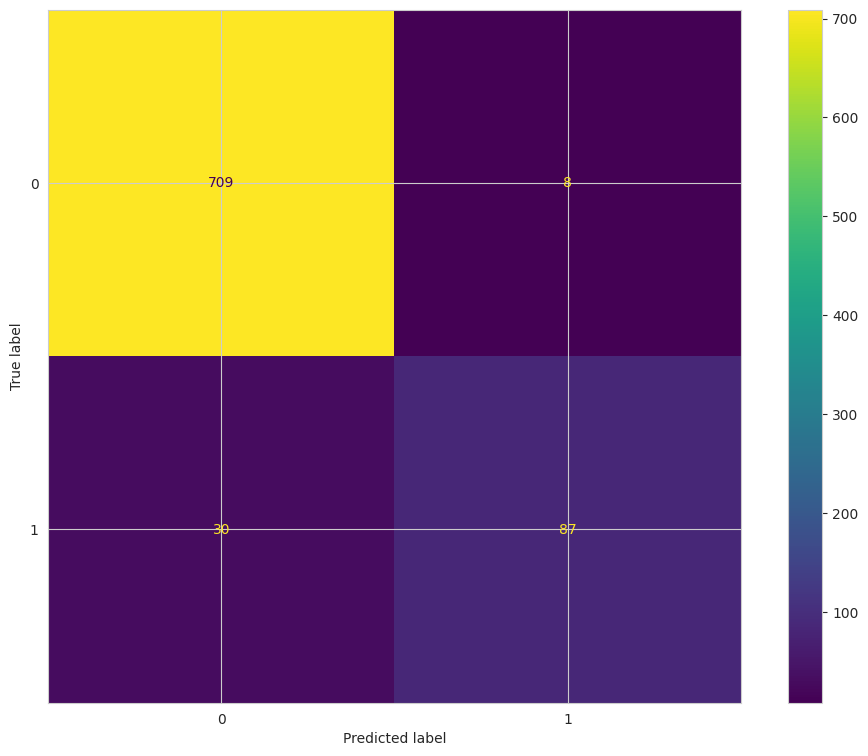

In [45]:
#давайте проверять на базе
cat_cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED, cat_features=['State'])
cat_cat.fit(X_train_cat, y_train_cat)
y_pred_cat_cat = cat_cat.predict(X_test_cat)

ConfusionMatrixDisplay(confusion_matrix(y_test_cat, y_pred_cat)).plot()
print(f'F1 score = {f1_score(y_test_cat, y_pred_cat_cat)}')
print(f'Коэффициент корреляции Мэтьюса = {matthews_corrcoef(y_test_cat, y_pred_cat_cat)}')

> Ну кстати уже на базовой моделе метрики лучше

> **Итого** по метрикам:
> * среди базовых (без подбора параметров) бустингов лучшая `lightgbm.LGBMClassifier` (f1~0.83)
> * среди базовых лесов лучший от xgboost `xgboost.XGBRFClassifier` (~0.78)
> * среди подобранных бустингов лучшая `xgboost.XGBClassifier` (~0.80)
> * среди подобранных лесов лучший от xgboost `xgboost.XGBRFClassifier` (~0.76)
> * метрика Мэтьюса: она ниже обычного f1-скора получалась, но разница не велика. Но возможно в других задачах с дисбалансом классов разрыв был бы больше.
> * catboost с категориальными (cat_cat): уже без подбора показал себя лучше, но не на много.

### Задание 5. Рисуем

**дополнительно 0.5 балла**

Наверняка, в процессе выполнения этого задания вас переполняли какие-то эмоции. Нарисуйте что-то, что бы могло бы передать их (я сам не умею, так что, если это будет просто квадрат, тоже подойдет). Прикрепите сюда свой рисунок:

In [ ]:
## PASTE YOUR MASTERPIECE HERE (/¯◡ ‿ ◡)/¯☆*##

![рисовать я не умею, но вот чему научилась аж ещё в детcком саду](../pic1.jpg)

### Therapy time

Напишите здесь ваши впечатления о задании (можно и не о задании): было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**

ну я всё ещё в шоке, что мы пишем код, а не просто запускаю склёрновские штуки...
(в позитивном ключе)

Но признаемся, что в этот раз миссия провалена
